# Import packages

In [2]:
#Suppress warnings 
import warnings
warnings.filterwarnings('ignore')
from collections import Counter


#Import packages 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#renders the figure inline (figure displayed directly below the cell) 
%matplotlib inline
import seaborn as sns
import plotly.graph_objects as go
import matplotlib.gridspec as gridspec
import itertools


from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score, KFold
from sklearn import metrics
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report, accuracy_score, f1_score
from sklearn import metrics
from sklearn.impute import KNNImputer
from mpl_toolkits.mplot3d import Axes3D
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import roc_auc_score
from sklearn.inspection import permutation_importance
from mlxtend.plotting import plot_decision_regions

# Data Exploration 

## Import and format data 

In [3]:
## Reading in the data and creating a new dataframe from which I can perform EDA


# Import and format data 
df = pd.read_csv('mammographic_masses.data', header=None) # reading in Mammographic Mass Data (MM)
labels = ['BI_RADS', 'Age', 'Shape', 'Mass_Margin', 'Mass_Density', 'Severity'] # creatng list of labels 
df = df.set_axis(labels, axis=1) # setting axis of df to labels list

In [4]:
## Creating a copy of the original dataframe 
MM_df = df.copy()

In [5]:
## Getting an overview of the dataframe 
# info will give the column name, datatype, non-null count 
MM_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 961 entries, 0 to 960
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   BI_RADS       961 non-null    object
 1   Age           961 non-null    object
 2   Shape         961 non-null    object
 3   Mass_Margin   961 non-null    object
 4   Mass_Density  961 non-null    object
 5   Severity      961 non-null    int64 
dtypes: int64(1), object(5)
memory usage: 45.2+ KB


## atrribute description 
   1. BI-RADS assessment: 2 to 5 (ordinal)  
   2. Age: patient's age in years (integer)
   3. Shape: mass shape (nominal)
       - round = 1 
       - oval = 2 
       - lobular = 3 
       - irregular = 4 
   4. Margin: mass margin (nominal)
       - circumscribed = 1 
       - microlobulated = 2 
       - obscured = 3 
       - ill-defined = 4 
       - spiculated = 5 
   5. Density: mass density (ordinal)
       - high = 1 
       - iso = 2 
       - low = 3 
       - fat-containing = 4 
   6. Severity: (binominal)
       - benign = 0
       - malignant = 1 

In [6]:
## quick glance at the first 5 rows of data 
MM_df.head() # note missing values are denoted by "?" --> replace with nan

,BI_RADS,Age,Shape,Mass_Margin,Mass_Density,Severity
0,5,67,3,5,3,1
1,4,43,1,1,?,1
2,5,58,4,5,3,1
3,4,28,1,1,3,0
4,5,74,1,5,?,1


In [7]:
## seeing the shape of the data 
MM_df.shape

(961, 6)

In [8]:
## recoding missing values
MM_df = MM_df.replace("?", np.nan) # replacing "?" with nan for ease of analaysis later 
MM_df.head() # checking df to ensure values were correctly replaced 

,BI_RADS,Age,Shape,Mass_Margin,Mass_Density,Severity
0,5,67,3,5,3,1
1,4,43,1,1,NaN,1
2,5,58,4,5,3,1
3,4,28,1,1,3,0
4,5,74,1,5,NaN,1


In [9]:
## looking at missing values in overall data set 
# not dropping missing values until post data split to avoid data leakage
# missing values will be dropped from the training and test set separately 

MM_df.isna().sum() # to see the total number of missing values in the overall dataset

BI_RADS          2
Age              5
Shape           31
Mass_Margin     48
Mass_Density    76
Severity         0
dtype: int64

In [10]:
## converting datatypes from objects to numeric

MM_df = MM_df.apply(pd.to_numeric) #applying to_numeric to change dtypes of values

print('The data types of variables in MM_df:\n')
print(MM_df.dtypes) #printing 

The data types of variables in MM_df:

BI_RADS         float64
Age             float64
Shape           float64
Mass_Margin     float64
Mass_Density    float64
Severity          int64
dtype: object


In [11]:
## exploring value counts
# can use a 'for' loop to explore each variable (minus 'age') in MM_df 
# used to identify miscoded values 

for column in MM_df:
    if column != 'Age': #a ge has a large var and would yield a large output - will look for outliers later  
        print(MM_df[column].value_counts()) # printing value counts for each variable

BI_RADS
4.0     547
5.0     345
3.0      36
2.0      14
6.0      11
0.0       5
55.0      1
Name: count, dtype: int64
Shape
4.0    400
1.0    224
2.0    211
3.0     95
Name: count, dtype: int64
Mass_Margin
1.0    357
4.0    280
5.0    136
3.0    116
2.0     24
Name: count, dtype: int64
Mass_Density
3.0    798
2.0     59
1.0     16
4.0     12
Name: count, dtype: int64
Severity
0    516
1    445
Name: count, dtype: int64


In [12]:
## manually dropping miscoded values from dataset 

drop = [0, 6, 55] # identified as miscoded values in MM_df 
MM_df.drop(MM_df.loc[MM_df['BI_RADS'].isin(drop)].index, inplace=True) # miscoded values found only in BI-RADS column

In [13]:
## checking to see if values were correctly dropped

MM_df['BI_RADS'].value_counts() #value_counts for BI_RADS column 

BI_RADS
4.0    547
5.0    345
3.0     36
2.0     14
Name: count, dtype: int64

In [14]:
#shape of the dataframe to further show mislabeled data was dropped 
#data went from 961 to 944 (difference of 17)
MM_df.shape

(944, 6)

In [15]:
#shape of the dataframe to further show mislabeled data was dropped 
#data went from 961 to 944 (difference of 17)
MM_df.shape

(944, 6)

In [16]:
## creating a mask which takes the number of missing values and divides the number by the length of the entire dataframe
# prints the percentage of missing values for each variable
# variables with more than 30% of values missing will be dropped

mask = (MM_df.isna().sum()/len(MM_df)).sort_values(ascending = False) # sorts values from highest % missing to lowest % missing
print('The percentage of missing values for each variable:\n') # print line introducing readout
print((mask*100))# print the mask to get the % of missing data 

The percentage of missing values for each variable:

Mass_Density    8.050847
Mass_Margin     4.978814
Shape           3.177966
Age             0.529661
BI_RADS         0.211864
Severity        0.000000
dtype: float64


### Table 1

In [17]:
### Table 1
# descriptive statistics of data (pre-test/train split)
#the data was rounded to the nearest whole integer 
#variables (with the expection of age) are not continuous, so values that were between scores would not properly represent the data. 
round(MM_df.describe().T)

,count,mean,std,min,25%,50%,75%,max
BI_RADS,942.0,4.0,1.0,2.0,4.0,4.0,5.0,5.0
Age,939.0,55.0,14.0,18.0,45.0,57.0,66.0,96.0
Shape,914.0,3.0,1.0,1.0,2.0,3.0,4.0,4.0
Mass_Margin,897.0,3.0,2.0,1.0,1.0,3.0,4.0,5.0
Mass_Density,868.0,3.0,0.0,1.0,3.0,3.0,3.0,4.0
Severity,944.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0


In [18]:
## looking value counts and percentage for severity class (outcome)
print('Value counts for severity class (outcome):') # print line introducing readout
print(MM_df['Severity'].value_counts())

print('\n') #adds a space between readouts

#using value counts to get percentage of data in each outcome class 
print('Percentage of total severity class (outcome):')# print line introducing readout
print(round(MM_df['Severity'].value_counts()/len(MM_df['Severity'])*100), 2)

Value counts for severity class (outcome):
Severity
0    511
1    433
Name: count, dtype: int64


Percentage of total severity class (outcome):
Severity
0    54.0
1    46.0
Name: count, dtype: float64 2


## Data visualization prior to test/split 

In [19]:
cont_var = ["Age"]
cat_var = ["BI_RADS", "Shape", "Mass_Margin", "Mass_Density", "Severity"]

### Figure 1
*Univariate Analysis*

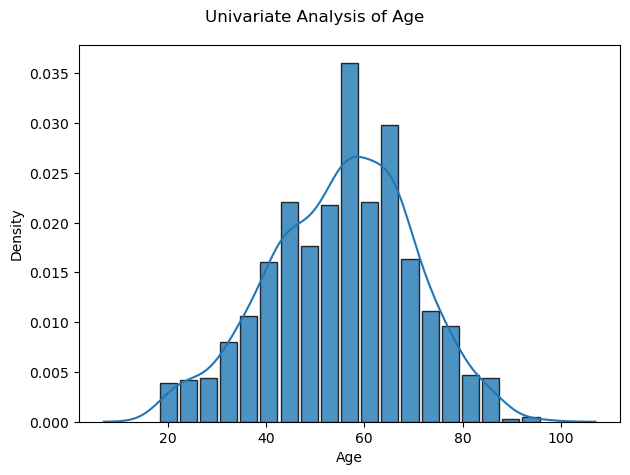

In [24]:
#Figure 1
#continuous variables

fig, axs = plt.subplots(nrows=1, ncols=1)
sns.distplot(MM_df[cont_var], ax=axs,
                 hist_kws={
                     'rwidth': 0.85,
                     'edgecolor': 'black',
                     'alpha': 0.8})
axs.set_xlabel('Age')
fig.suptitle("Univariate Analysis of Age", fontsize = 12)
plt.tight_layout()
plt.show()

In [21]:
def categorical_analysis(df, cols, hue=None, rows=2, columns=3):
    """Labelled and color-coded visualizations of categorical (including binary) variables."""
    fig, axes = plt.subplots(rows, columns, figsize=(10, 8))
    axes = axes.flatten()
    
    for var, count in zip(cols, axes):
        sns.countplot(x=var,
                      data=df,
                      hue=hue,
                      ax=count,
                      order=df[var].value_counts().index)
        count.tick_params()        
        total = float(len(df[var]))        
        count.set_title(f'{str(var).capitalize()}')
        
        for p in count.patches:
            height = p.get_height()
            count.text(p.get_x() + p.get_width() / 2.,
                       height + 2,
                       '{:1.2f}%'.format((height / total) * 100),
                       ha='center')
        
    plt.tight_layout()

### Figure 2
*categorical analysis*

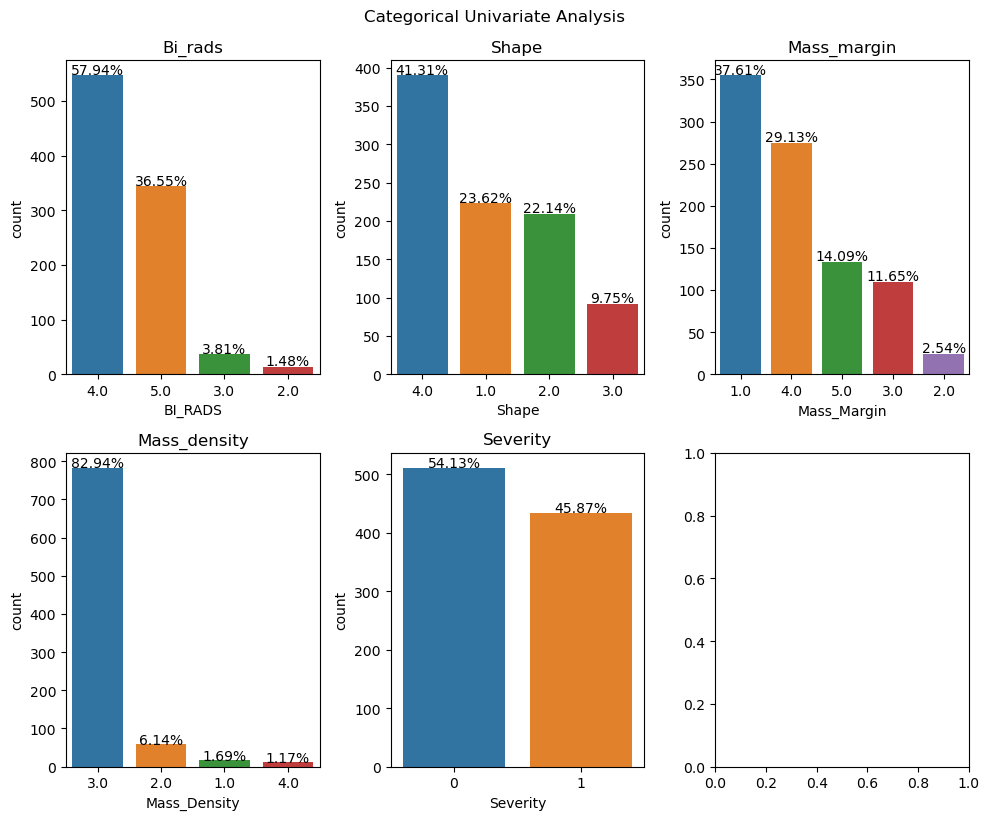

In [23]:
#figure 2
categorical_analysis(MM_df, cat_var)
plt.suptitle("Categorical Univariate Analysis", fontsize = 12, y = 1.02)
plt.show()

### Figure 3
*Bivariate Analysis vs Target*

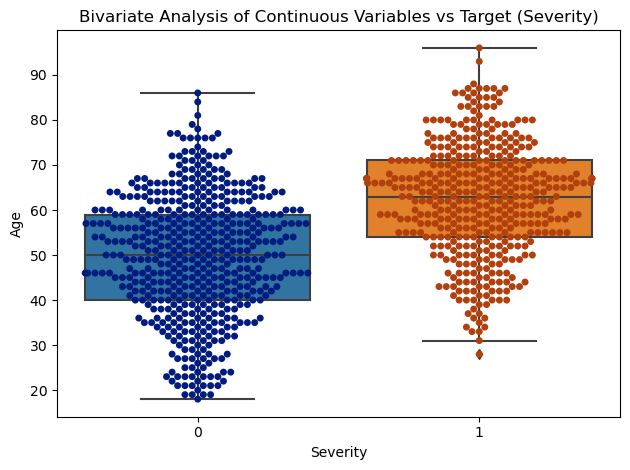

In [25]:
#figure 3
# Custom color palette for box and swarm plots
swarmplot_colors = sns.color_palette("dark")

# Create the box plot
sns.boxplot(x="Severity", y=MM_df["Age"], data=MM_df)

# Create the swarm plot with adjusted hue
sns.swarmplot(x="Severity", y=MM_df["Age"], data=MM_df, palette=swarmplot_colors)

# Set the title and adjust the layout
plt.title("Bivariate Analysis of Continuous Variables vs Target (Severity)", fontsize=12)
plt.tight_layout()
plt.show()

### Figure 4
*categorical bivariate analysis*

Text(0.5, 1.01, 'Categorical Bivariate Analysis by Target (Severity)')

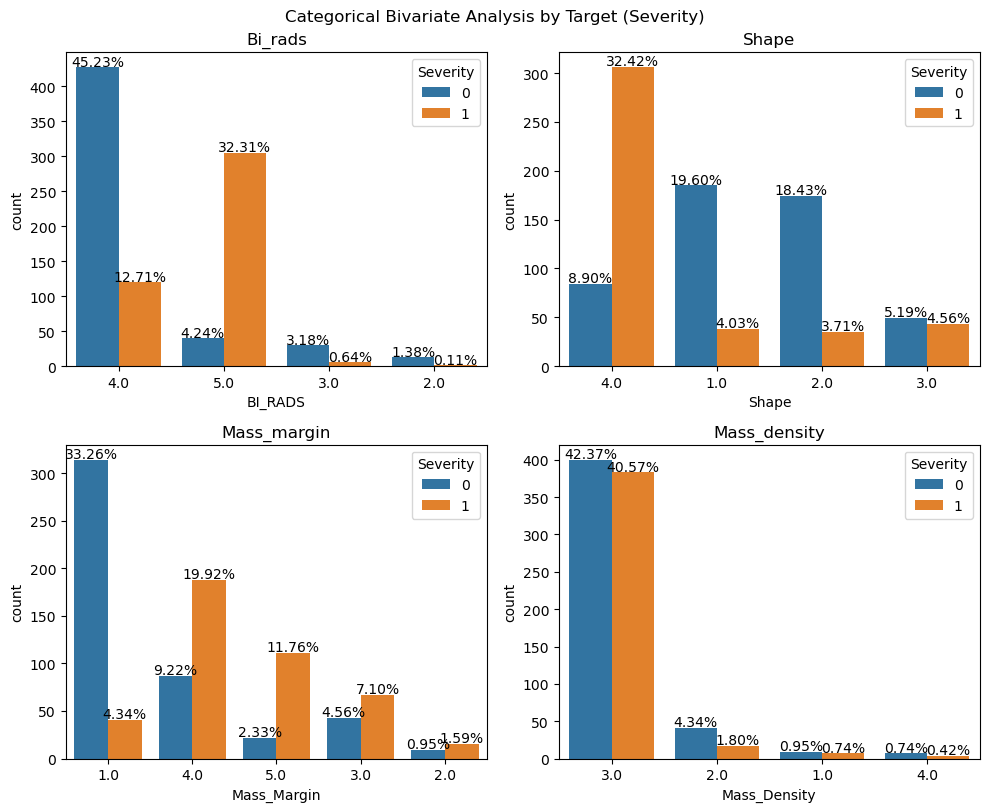

In [26]:
#figure 4
# categorical bivariate analysis
categorical_analysis(MM_df, cat_var, hue = 'Severity', rows = 2, columns =2)
plt.suptitle("Categorical Bivariate Analysis by Target (Severity)", fontsize = 12, y = 1.01)

### Figure 5
*pairplot analysis*

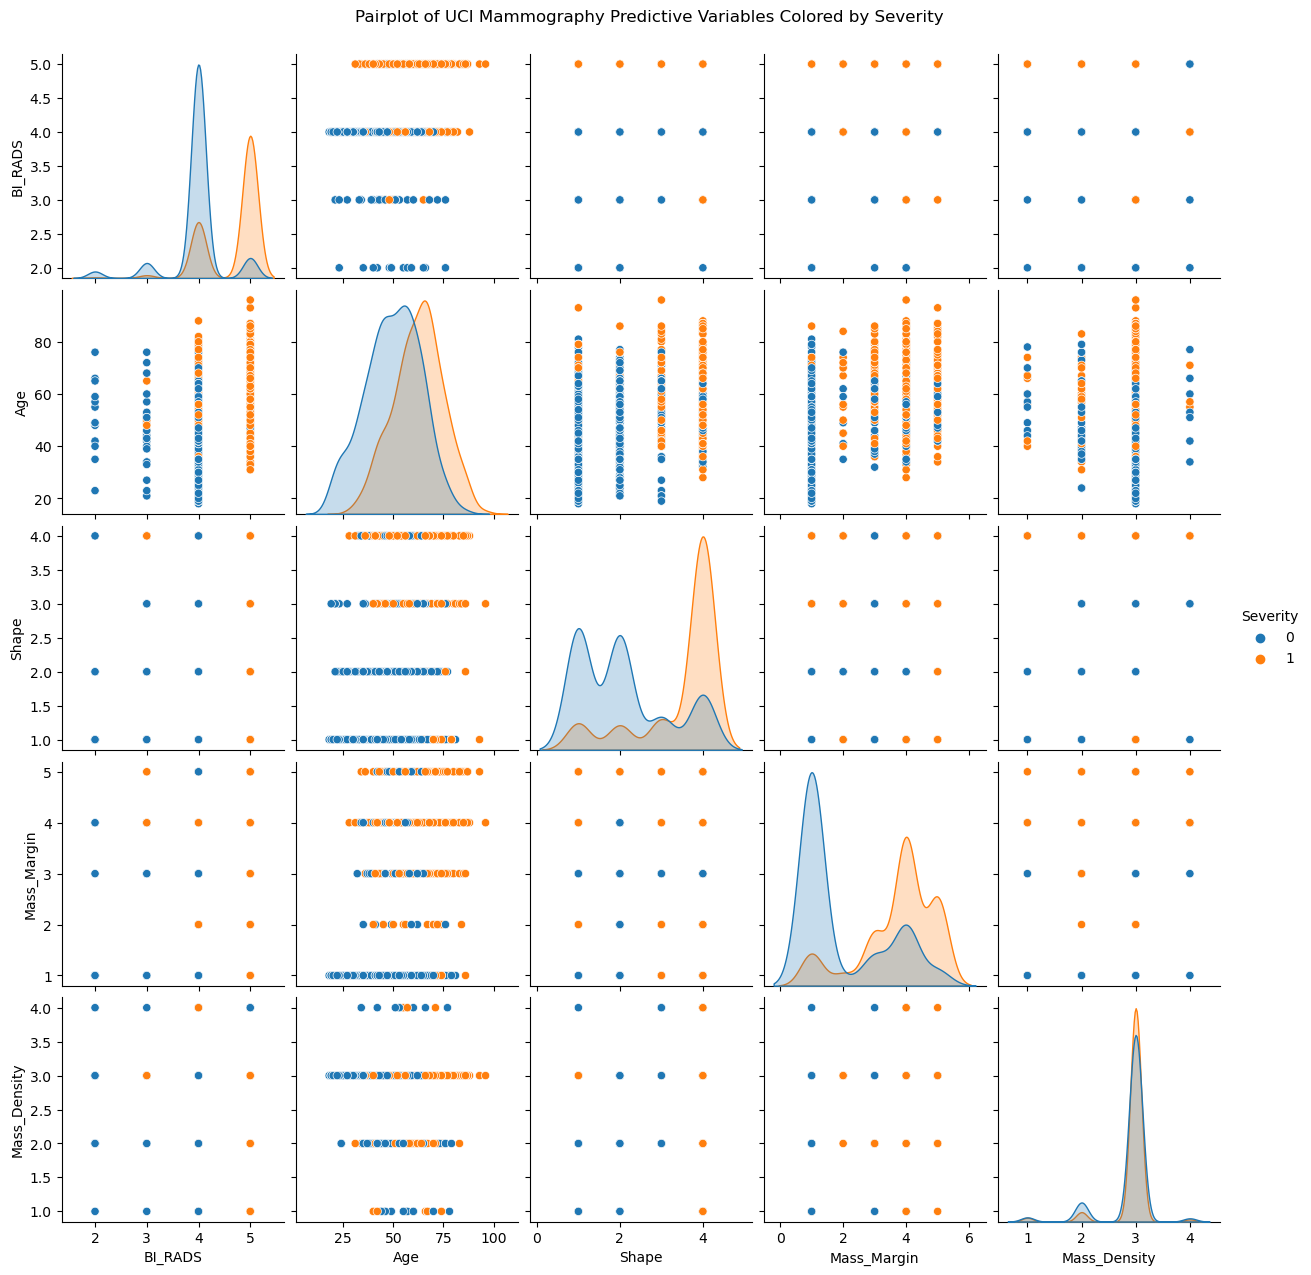

In [309]:
### Figure 5
# pairplot to visualize the distribution of data and the correlation between different features in the dataset.

sns.pairplot(MM_df, hue='Severity') # creation of a pairplot with severity (outcome) serving as hue
plt.suptitle("Pairplot of UCI Mammography Predictive Variables Colored by Severity", y=1.02) # set title 
plt.show() #shows the graph  

### Figure 6
*heatmap*

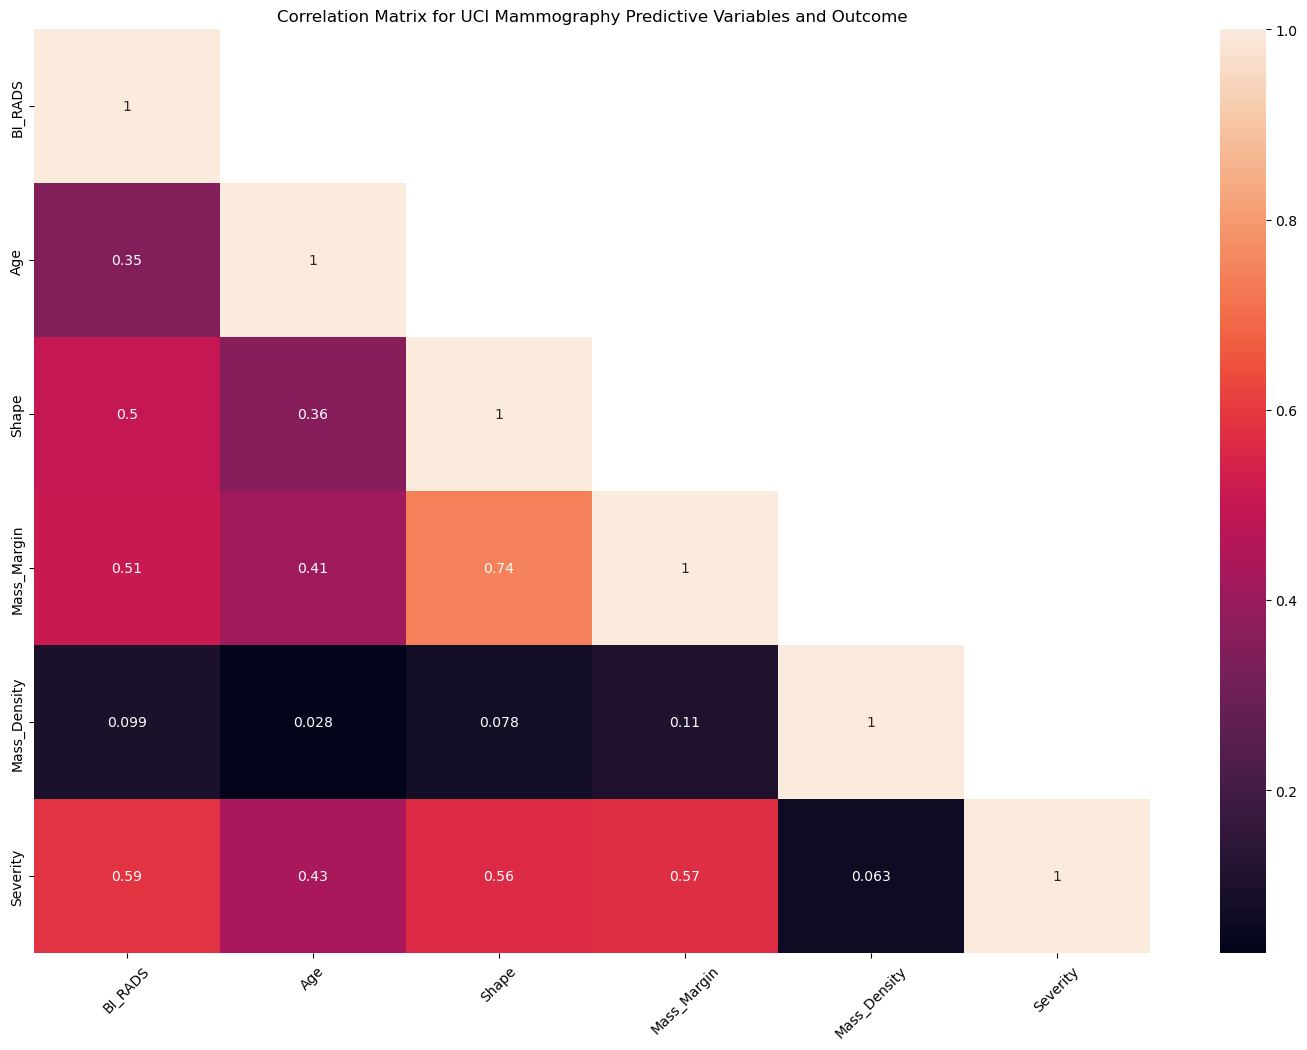

In [310]:
### Figure 6
#heatmap visualization of correlation index 

# Compute the correlation matrix
corr_matrix = MM_df.corr()
# Create a mask for the upper triangle
mask = np.triu(np.ones(corr_matrix.shape), k=1)
# Create the heatmap with the masked upper triangle
ax = sns.heatmap(corr_matrix, annot=True, mask=mask)
# Set x-axis labels at a 45-degree rotation
plt.setp(ax.get_xticklabels(), rotation=45)
# Set the figure size
plt.rcParams['figure.figsize'] = (18, 12)
# Set the title
plt.title('Correlation Matrix for UCI Mammography Predictive Variables and Outcome')

plt.show() 

In [311]:
## numeric description of correlation between features 
MM_df.corr()

,BI_RADS,Age,Shape,Mass_Margin,Mass_Density,Severity
BI_RADS,1.000000,0.347814,0.496042,0.509610,0.098828,0.585002
Age,0.347814,1.000000,0.361109,0.410814,0.028268,0.434327
Shape,0.496042,0.361109,1.000000,0.742708,0.078040,0.559919
Mass_Margin,0.509610,0.410814,0.742708,1.000000,0.109338,0.574663
Mass_Density,0.098828,0.028268,0.078040,0.109338,1.000000,0.063072
Severity,0.585002,0.434327,0.559919,0.574663,0.063072,1.000000


### Figure 7
*heatmap with target (severity)*

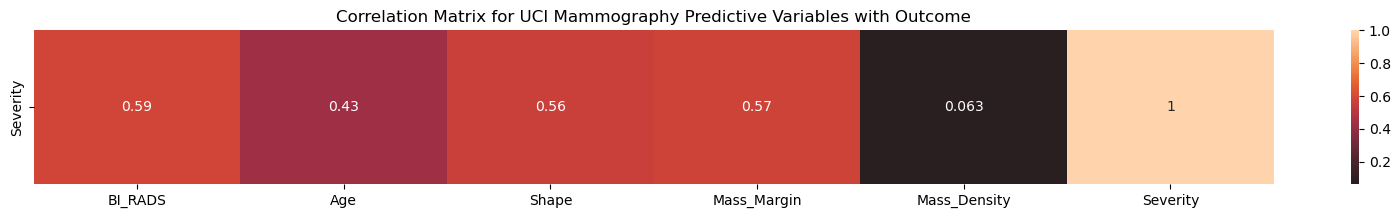

In [312]:
### Fiugure 7
#heatmap visualization of features and their correlation with the target, severity 
plt.figure(figsize=(20,2)) # establish figure size
ax = sns.heatmap((MM_df.corr()).sort_values(by=["Severity"], ascending=False).head(1), center=0, annot = True) #defining graph varibles
plt.title('Correlation Matrix for UCI Mammography Predictive Variables with Outcome')
plt.show()

In [313]:
## numeric description of heatmap 
MM_df.corr().sort_values(by=["Severity"], ascending=False).head(1) #sorting values by severity

,BI_RADS,Age,Shape,Mass_Margin,Mass_Density,Severity
Severity,0.585002,0.434327,0.559919,0.574663,0.063072,1.0


### Figure 8
*features in 3D space*

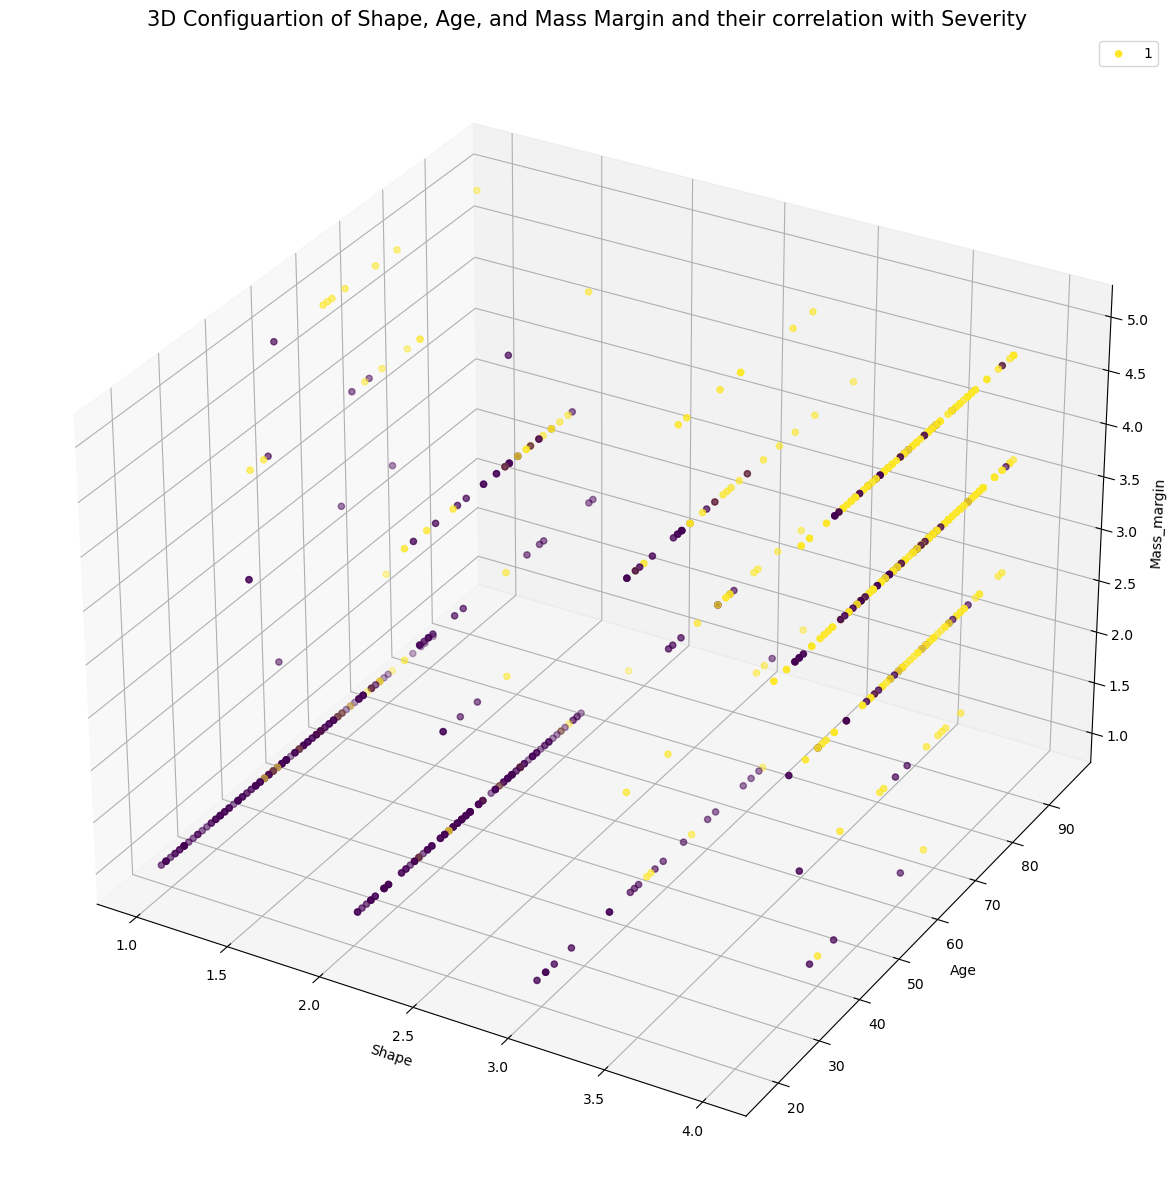

In [412]:
### Figure 8
# exploring features in three-dimensional (3D) space  


#Creating new variables that contain only values of features of interest
bi_rads = MM_df['Shape'].values
age = MM_df['Age'].values
mass_margin = MM_df['Mass_Margin'].values
severity = MM_df['Severity'].values

#the labels of points will be defined by the outcome 
labels = MM_df['Severity']

#Plot figure that shows how the 3 top features interact with the outcome
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(projection='3d')
ax.scatter(bi_rads, age, mass_margin, c = severity)
ax.set_xlabel('Shape')
ax.set_ylabel('Age')
ax.set_zlabel('Mass_margin')

plt.legend(labels = labels)
plt.title('3D Configuartion of Shape, Age, and Mass Margin and their correlation with Severity', size=15)

plt.show()

# Data Pre-processing 

## Define training and testing sets

In [354]:
### Pre-processing
## working through training set, then applying same preprocessing steps to test set 

#Stratified sampling
# Create a DataFrame with all columns except for mass_density (weak correlation with outcome) and Severity (outcome)
#BI_RADS is not predictive of severity, so drop from analysis 
X = MM_df.iloc[:, 1:4]

# Create a Severity labels dataset
y = MM_df.iloc[:, 5]

# Use stratified sampling to split up the dataset according to the y dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

### Training set

In [355]:
## printing dimensions of the training set 
print('The dimensions of the training set are:')
print ('X_train dimensions: ', X_train.shape)
print ('y_train dimensions: ', y_train.shape)

The dimensions of the training set are:
X_train dimensions:  (755, 3)
y_train dimensions:  (755,)


In [356]:
# Printing class distribution of the training set 
print('Value counts for severity class (outcome) in training set:')
print(y_train.value_counts()/len(y_train))

Value counts for severity class (outcome) in training set:
Severity
0    0.541722
1    0.458278
Name: count, dtype: float64


In [357]:
### implementing RandomOverSampler to balance class distribution of training set  

OS = RandomOverSampler() #instantiating RandomOverSampler
X_train, y_train = OS.fit_resample(X_train, y_train) #fitting OS to training data 

In [358]:
#printing the new lengths of the training set
print('New length of training set after Random Oversampling:')
print(len(X_train))
print(len(y_train))

print('\n') #creating space between readouts

#printing to see that RandomOverSampler 
print('New value counts for severity class (outcome) in training set after Random Oversampling:')
print(y_train.value_counts()/len(y_train))

New length of training set after Random Oversampling:
818
818


New value counts for severity class (outcome) in training set after Random Oversampling:
Severity
0    0.5
1    0.5
Name: count, dtype: float64


In [359]:
y_train.value_counts()

Severity
0    409
1    409
Name: count, dtype: int64

### Figure 9
*Value counts after random oversampling*

Text(0.5, 1.0, 'Value Counts for Benign (0) vs. Malignant (1) in Training Set after Random Oversampling')

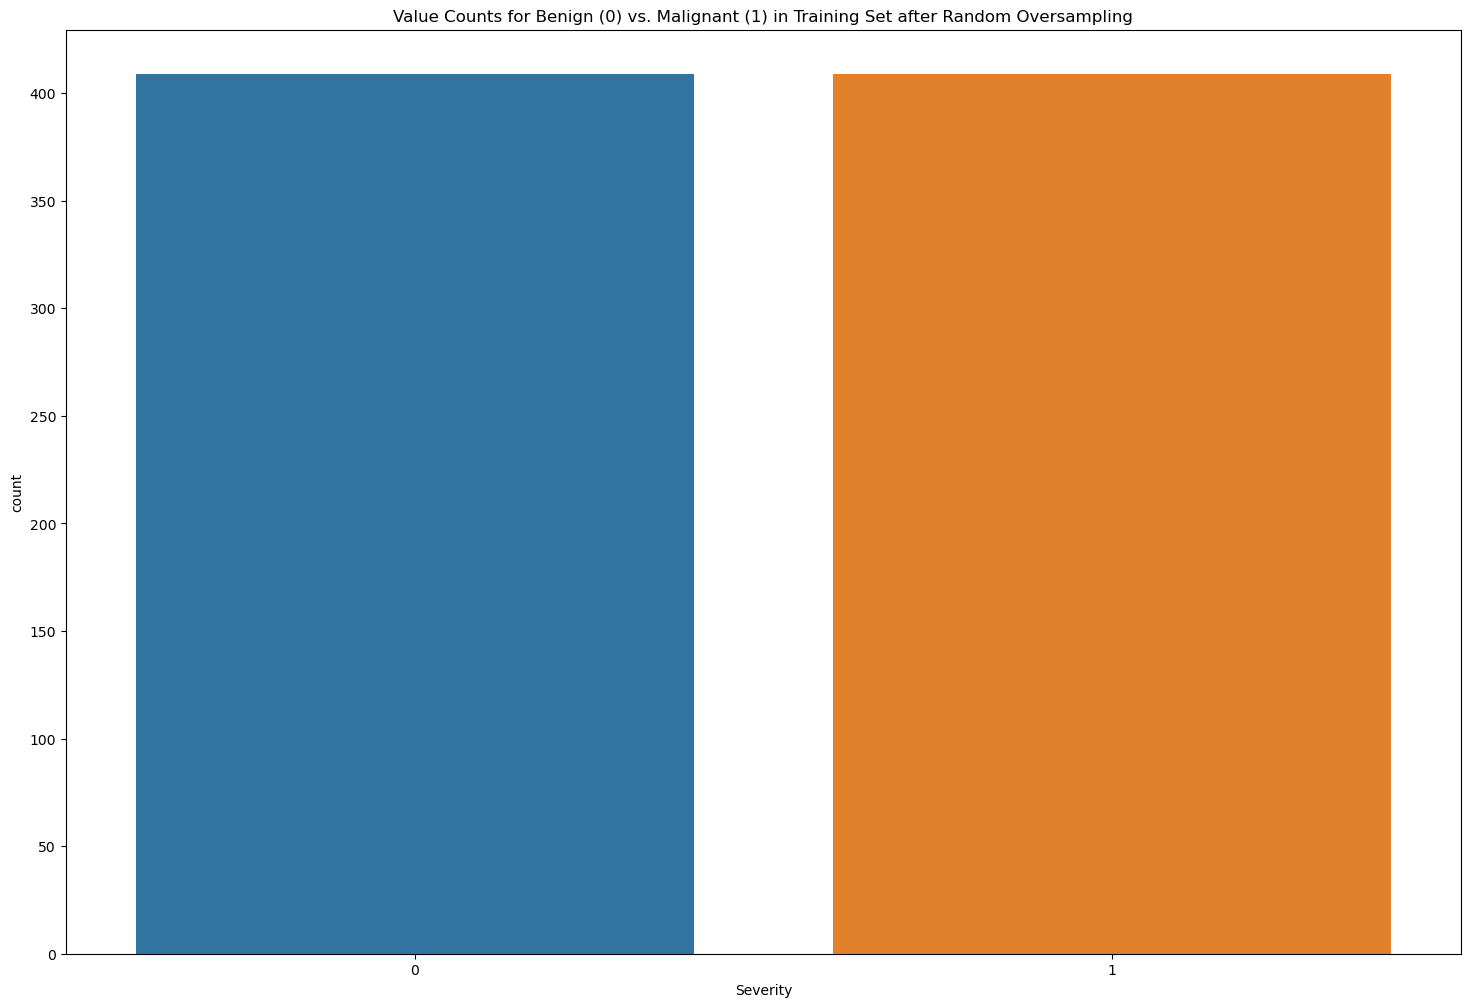

In [360]:
### Figure 9
## countplot of the severity scores for data (post-test/train split)
fig, ax = figsize=(15, 5)
count_plot = sns.countplot(x=y_train)
count_plot.set_title( "Value Counts for Benign (0) vs. Malignant (1) in Training Set after Random Oversampling")

In [361]:
## dropping missing data from dataframe POST test/split to prevent data leakage

## X_train
#printing the total number of missing values from training set 
print('Number of missing values from training set:')
print(X_train.isna().sum())

#dropping nan values from traning set prior to standard scaling 
X_train = X_train.dropna()

print('\n') #creates space between printouts 

#printing to ensure missing values were dropped 
print('New number of missing values from training set (after missing values dropped):')
print(X_train.isna().sum())

print('\n') #creates space between printouts 

##y_train
#reindexing y_train, so that it is the same length as the X_train set 
y_train = y_train.reindex(X_train.index)

#ensuring that X and y training sets are the same length 
print('New length of training sets after missing values were dropped and reindexing:')
print(len(X_train))
print(len(y_train))

print('\n') #creates space between printouts 

#making sure that y_train contains no missing values
print('Number of missing values from training set for outcome:')
print(y_train.isna().sum())

#converting y_train to numpy array so that it can be used in training of the supervised machine learning (SML) models
y_train = y_train.to_numpy()

Number of missing values from training set:
Age             5
Shape          25
Mass_Margin    39
dtype: int64


New number of missing values from training set (after missing values dropped):
Age            0
Shape          0
Mass_Margin    0
dtype: int64


New length of training sets after missing values were dropped and reindexing:
758
758


Number of missing values from training set for outcome:
0


### Test set

In [362]:
## printing the the dimensions of test set 
print('The dimensions of the test set are:')
print ('X_test dimensions: ', X_test.shape)
print ('y_test dimensions: ', y_test.shape)

The dimensions of the test set are:
X_test dimensions:  (189, 3)
y_test dimensions:  (189,)


In [363]:
## applying same transformations to the test set as done in the training set
# the only exception is random over sampling

## X_test 
#printing the total number of missing values from test set 
print('Number of missing values from test set:')
print(X_test.isna().sum())

print('\n') #creates space between printouts

#dropping nan values from test set prior to standard scaling
X_test = X_test.dropna()

#printing to ensure missing values were dropped
print('New number of missing values from training set (after missing values dropped):')
print(X_test.isna().sum())

print('\n') #creates space between printouts

## y_test 
#reindexing y_test, so that it is the same length as the X_test set 
y_test = y_test.reindex(X_test.index)
print('New length of training sets after missing values were dropped and reindexing:')
print(len(X_test))
print(len(y_test))

print('\n') #creates space between printouts

print('Number of missing values from training set for outcome:')
print(y_test.isna().sum())

#converting y_test to numpy array so that it can be used in training of the SML models
y_test = y_test.to_numpy()

Number of missing values from test set:
Age            0
Shape          6
Mass_Margin    9
dtype: int64


New number of missing values from training set (after missing values dropped):
Age            0
Shape          0
Mass_Margin    0
dtype: int64


New length of training sets after missing values were dropped and reindexing:
175
175


Number of missing values from training set for outcome:
0


## Feature scaling 

### Figure 10

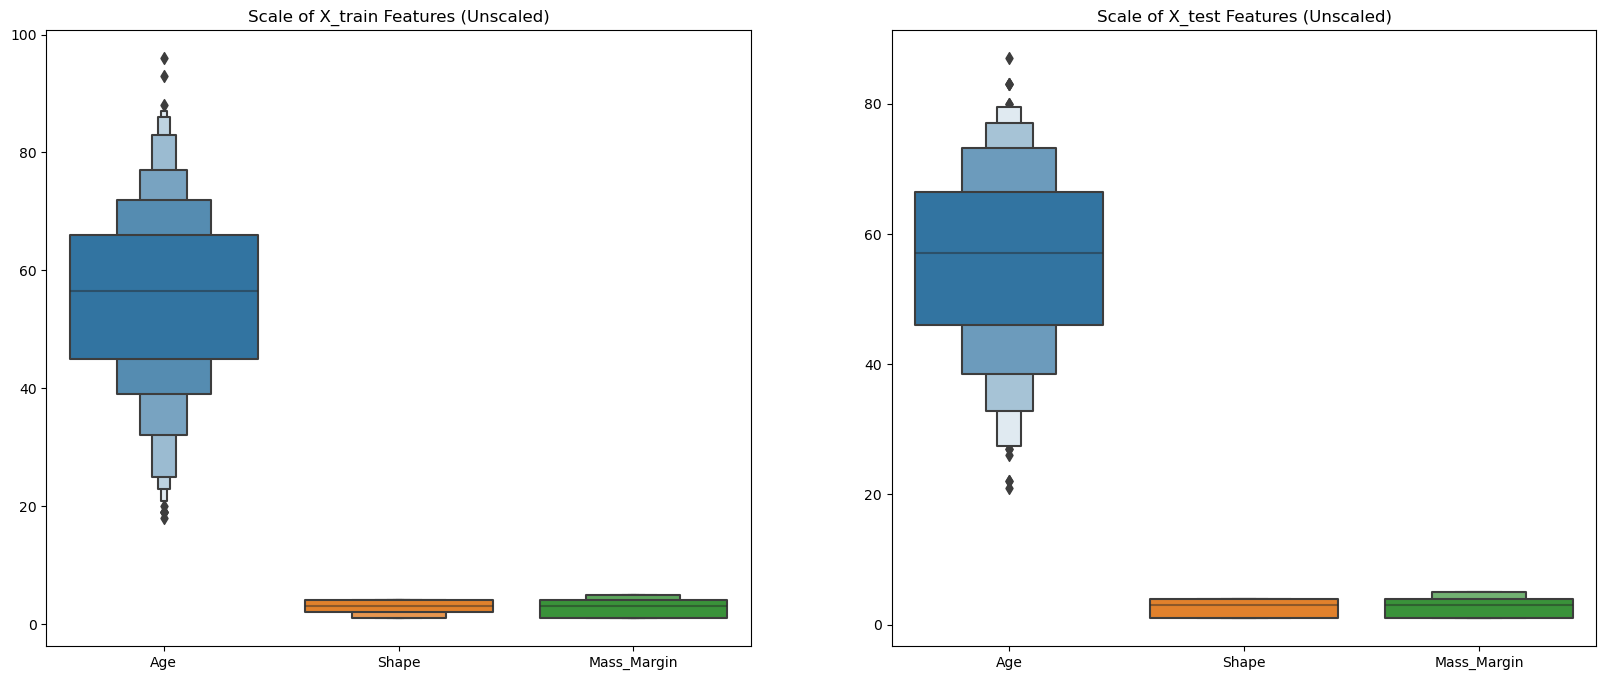

In [364]:
### Figure 10
## visualizing unscaled features for X_train and X_test 

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,8)) # setting figure dimensions 
sns.boxenplot(data=X_train, ax=ax1) # creation of boxen plot for train set 
plt.xticks() # plotting x ticks 
ax1.set_title('Scale of X_train Features (Unscaled)') # setting title 

sns.boxenplot(data=X_test, ax=ax2) # creation of boxen plot for test set 
plt.xticks() # plotting x ticks 
ax2.set_title('Scale of X_test Features (Unscaled)') # setting title 
plt.show() # displaying graph 

In [365]:
### implementation of Standard Scaler 
## standard scaler scales the features to have zero mean and unit variance

scaler = StandardScaler() #instantiating StandardScaler 

#fitting the StandardScaler to X_train and X_test to produce numpy arrays
#will use these arrays to fit SML models
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [366]:
##confirmation that the lengths of the unscaled and scaled arrays are the same
#no values lost 

print('Lengths of unscaled and scaled X_train:')
print('X_train (unscaled):', len(X_train))
print('X_train (unscaled):', len(X_train_scaled))
print('\n')
print('Lengths of unscaled and scaled X_test:')
print('X_test (unscaled):',len(X_test))
print('X_test (scaled):',len(X_test_scaled))

Lengths of unscaled and scaled X_train:
X_train (unscaled): 758
X_train (unscaled): 758


Lengths of unscaled and scaled X_test:
X_test (unscaled): 175
X_test (scaled): 175


### Figure 11

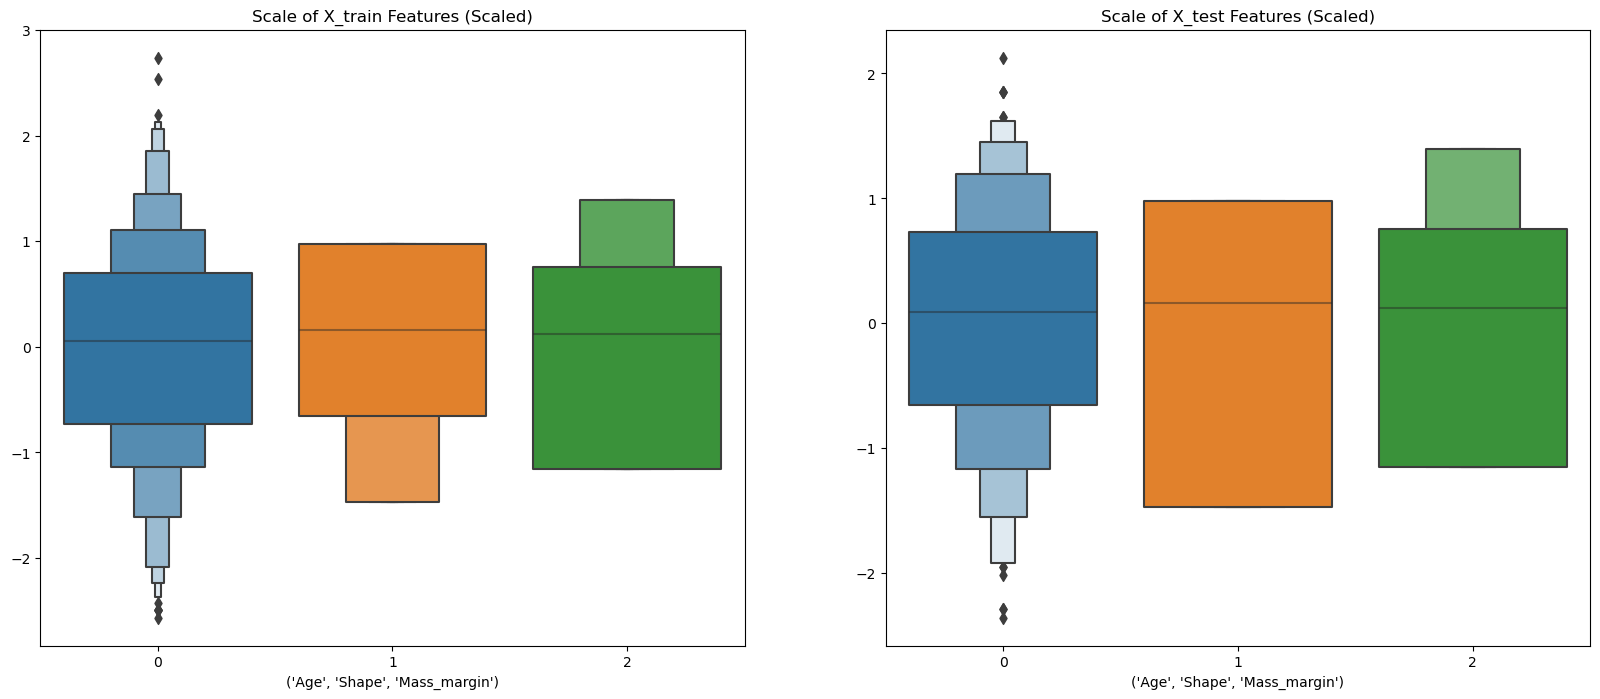

In [367]:
### Figure 11
## visualizing scaled features for X_train and X_test

labels = ('Age', 'Shape', 'Mass_margin')

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,8)) # setting figure dimensions 
sns.boxenplot(data=X_train_scaled, ax = ax1).set(xlabel=labels) # creation of boxen plot for train set 
plt.xticks() # set x ticks 
ax1.set_title('Scale of X_train Features (Scaled)') # setting title 

sns.boxenplot(data=X_test_scaled, ax = ax2).set(xlabel=labels) # creation of boxen plot for test set
plt.xticks() # set x ticks 
ax2.set_title('Scale of X_test Features (Scaled)')
plt.show() # displaying graph 

# Model Selection 

In [368]:
### Model selection

#using pipeline to quickly select the 2 best SML models for the dataset
#pipeline consists of k-NN, Decision Tree Classifier, Random Forest Classifer, and Support Vector Classifier (SVC)

pipeline_knn=Pipeline([('KNeighborsClassifier', KNeighborsClassifier())])

pipeline_dt=Pipeline([ ('dt_classifier',DecisionTreeClassifier(random_state=42))])

pipeline_rf=Pipeline([('rf_classifier',RandomForestClassifier(random_state=42))])

pipeline_svc=Pipeline([('sv_classifier',SVC(random_state=42))])

#list of pipelines
pipelines = [pipeline_knn, pipeline_dt, pipeline_rf, pipeline_svc]

#dictionary of pipelines and classifiers for reference
pipeline_dict = {0: 'KNeighborsClassifier', 1: 'Decision Tree', 2: 'Random Forest', 3: 'SVC'}

# Fit the pipelines
for pipe in pipelines:
    pipe.fit(X_train_scaled, y_train)

#Area under receiver operating characteristic (ROC) Curve (roc_auc) scores for models
#roc_auc tells you the efficiency of the model 
#closer scores to 1 indicate better efficiency 

for i, model in enumerate(pipelines):
    pred_model = model.predict(X_test_scaled)
    roc_auc = roc_auc_score(y_test, pred_model)
    print("%s: %f " % (pipeline_dict[i], roc_auc))

print('------')

#cross validation on roc_auc  
cv_results_roc= []
for i, model in enumerate(pipelines):
    cv_score = cross_val_score(model, X_test_scaled,y_test, cv=10, scoring= 'roc_auc')
    cv_results_roc.append(cv_score)
    print("%s: %f " % (pipeline_dict[i], cv_score.mean()))

KNeighborsClassifier: 0.842522 
Decision Tree: 0.800943 
Random Forest: 0.814170 
SVC: 0.853981 
------
KNeighborsClassifier: 0.865640 
Decision Tree: 0.786983 
Random Forest: 0.860617 
SVC: 0.888241 


### Figure 12 

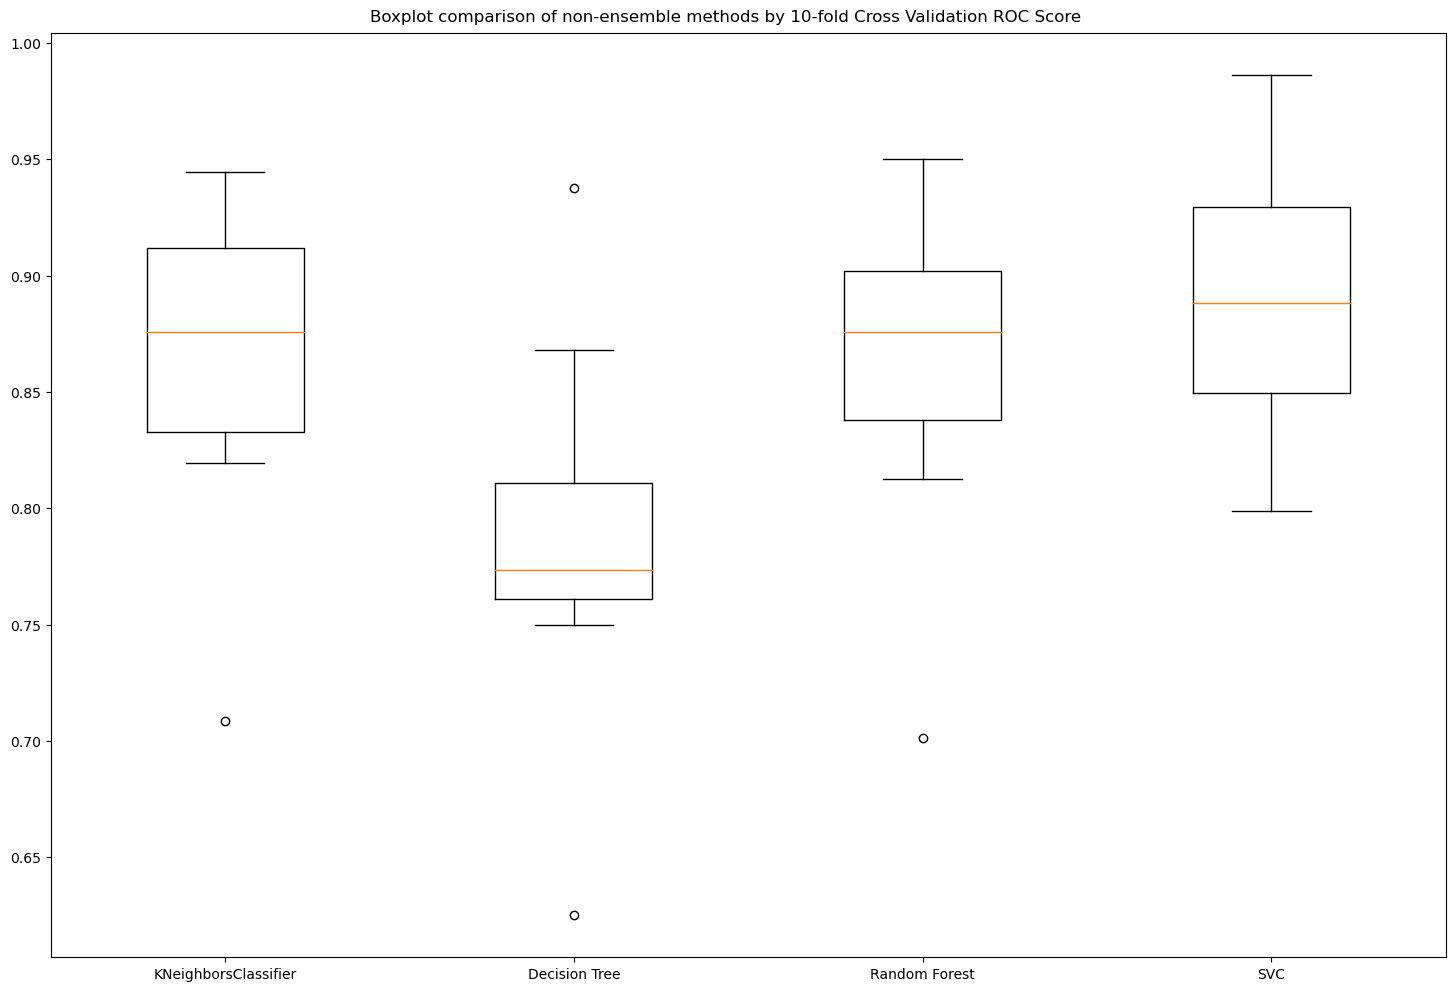

In [369]:
### Figure 12
#visually comparing models found in pipeline 

fig, ax = plt.subplots()
fig.suptitle('Boxplot comparison of non-ensemble methods by 10-fold Cross Validation ROC Score', y = 0.90) # setting title 
plt.boxplot(cv_results_roc) # creation of box plot with ROC cv_scores
ax.set_xticklabels(pipeline_dict.values()) # labeling x-axis with model names
plt.show() # displaying graph 

## k-NN

### Pseudocode for k-NN

## k-NN (without hyper-parameter selection)

In [370]:
## instantiating and fitting k-NN model

knn = KNeighborsClassifier() #instantiating classifier
knn.fit(X_train_scaled, y_train)  #fitting knn to training data 

KNeighborsClassifier()

In [371]:
## performing metrics on X_train_scaled 

#predicting severity score based off training values 
y_pred_train_knn = knn.predict(X_train_scaled)

#cross validation (CV) scores for training data
cv_score_train_knn = cross_val_score(knn, X_train_scaled,y_train, cv=10, scoring='roc_auc')

#mean CV score (of 10)
print(f"The average CV score on training set = {round(cv_score_train_knn.mean(), 3)}")
print('\n')
#classification report using y_train vs. y__train_predicted 
print('Classification report for training set (k_NN)')
print(classification_report(y_train, y_pred_train_knn))

#printing the roc_auc score for the training set
print("Train ROC score:",roc_auc_score(y_pred_train_knn, y_train))

score_knn_train = knn.score(X_train_scaled, y_train)
print(f"R^2(coefficient of determination) on training set = {round(score_knn_train, 3)}")

The average CV score on training set = 0.819


Classification report for training set (k_NN)
              precision    recall  f1-score   support

           0       0.86      0.78      0.82       372
           1       0.81      0.88      0.84       386

    accuracy                           0.83       758
   macro avg       0.83      0.83      0.83       758
weighted avg       0.83      0.83      0.83       758

Train ROC score: 0.8340448013524938
R^2(coefficient of determination) on training set = 0.831


In [372]:
## performing metrics on X_test_scaled 

#predicting severity score based of test values 
y_pred_test_knn = knn.predict(X_test_scaled)

#cross validation (CV) scores for test data 
cv_score_test_knn = cross_val_score(knn, X_test_scaled,y_test, cv=10, scoring='roc_auc')

print(f"The average CV score on test set = {round(cv_score_test_knn.mean(), 3)}")

print('\n')

#classification report using y_test vs. y_predicted 
print('Classification report for test set (k_NN)')
print(classification_report(y_test, y_pred_test_knn))
print('\n')

#printing the roc_auc score for the test set 
print("Test ROC score:",roc_auc_score(y_pred_test_knn, y_test))


score_random_forest_test = knn.score(X_test_scaled, y_test)
print(f"R^2(coefficient of determination) on testing set = {round(score_random_forest_test, 3)}")

The average CV score on test set = 0.866


Classification report for test set (k_NN)
              precision    recall  f1-score   support

           0       0.89      0.79      0.84        92
           1       0.80      0.89      0.84        83

    accuracy                           0.84       175
   macro avg       0.84      0.84      0.84       175
weighted avg       0.85      0.84      0.84       175



Test ROC score: 0.8429714135851036
R^2(coefficient of determination) on testing set = 0.84


### visualization of model outcomes 

### Figure 13

Text(0.5, 1.0, 'AUC ROC from Predictions (k_NN)')

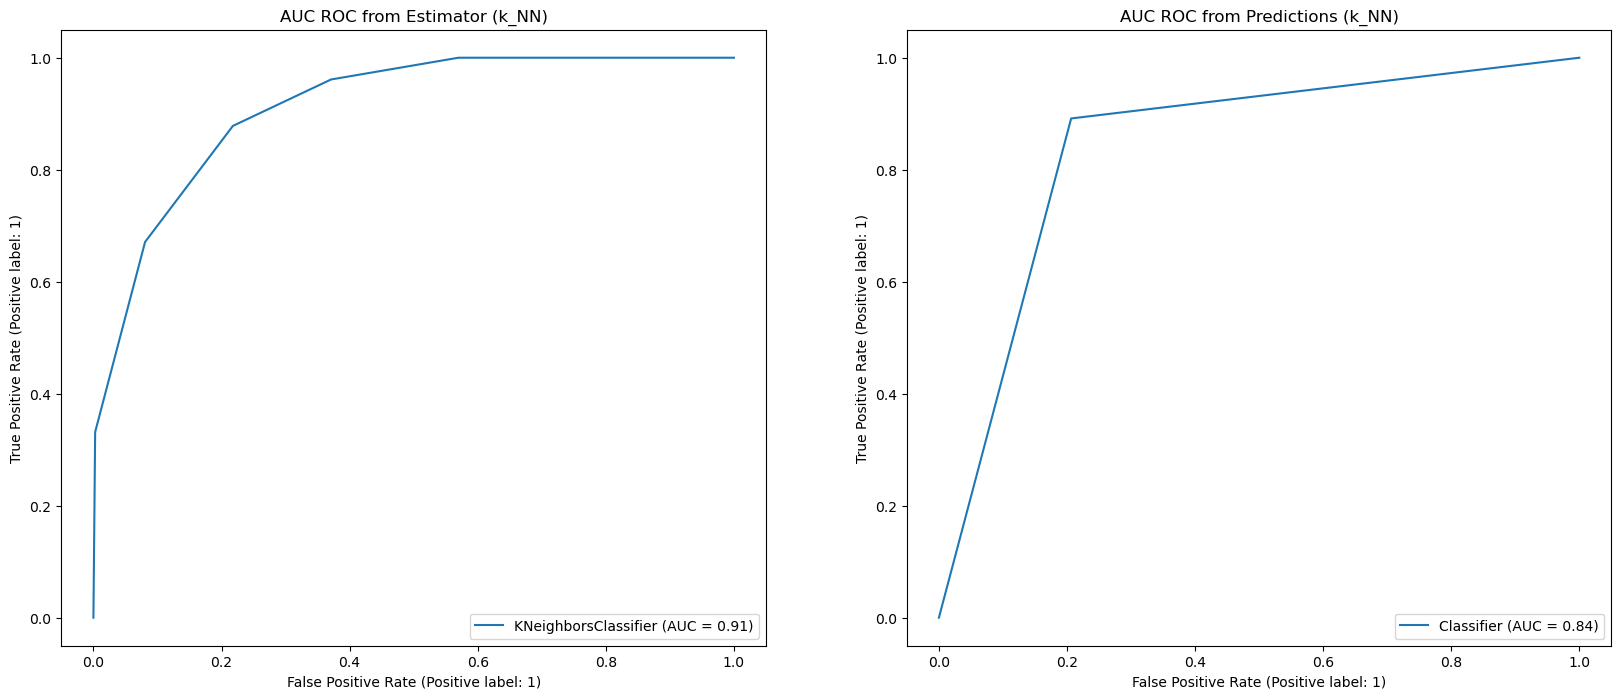

In [373]:
### Figure 13
#displaying roc_auc for test data

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,8))

#'from_estimator' plots the ROC curve on the model that has already been fit to data
RocCurveDisplay.from_estimator(knn, X_train_scaled, y_train, ax = ax1)
ax1.set_title('AUC ROC from Estimator (k_NN)')
#'from_predictor' plots the ROC curve using predicted scores or probabilities and the true binary labels
RocCurveDisplay.from_predictions(y_test, y_pred_test_knn, ax = ax2)
ax2.set_title('AUC ROC from Predictions (k_NN)')

### Figure 14

Text(0.5, 0.98, 'KNN Confusion Matrix')

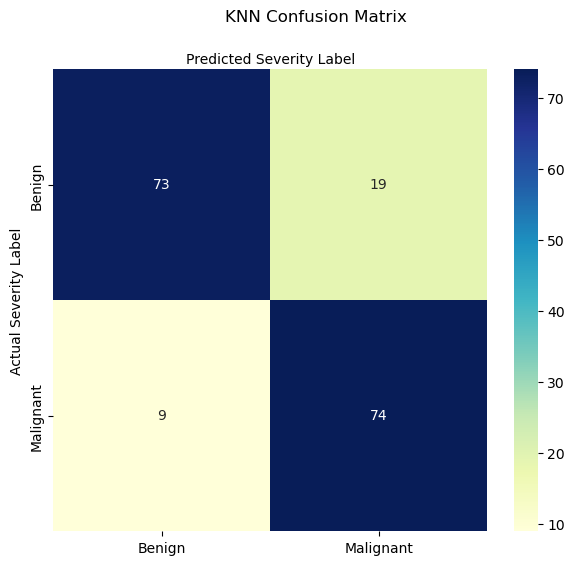

In [374]:
### Figure 14
##heatmap showing the confusion matrix for true positives (TP), true negtaives (TN), false positives (FP), and false negatives (FN)

#specifing plot parameters 
class_names = ['Benign', 'Malignant'] # name of classes 
title = 'KNN Confusion Matrix'
ylabel = 'Actual Severity Label'
xlabel = 'Predicted Severity Label'
tick_marks = [0.5, 1.5]
data = pd.DataFrame(confusion_matrix(y_test, y_pred_test_knn))
figsize = (7,6)

#plot figure
fig, ax = plt.subplots(figsize=figsize)
sns.heatmap(data, annot=True, cmap="YlGnBu", fmt='g')
ax.xaxis.set_label_position("top")
plt.ylabel(ylabel)
plt.xlabel(xlabel)
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
plt.suptitle(title)

### Figure 15

Text(0.5, 0.9, 'Permutation Importance of Predictive Variables in knn')

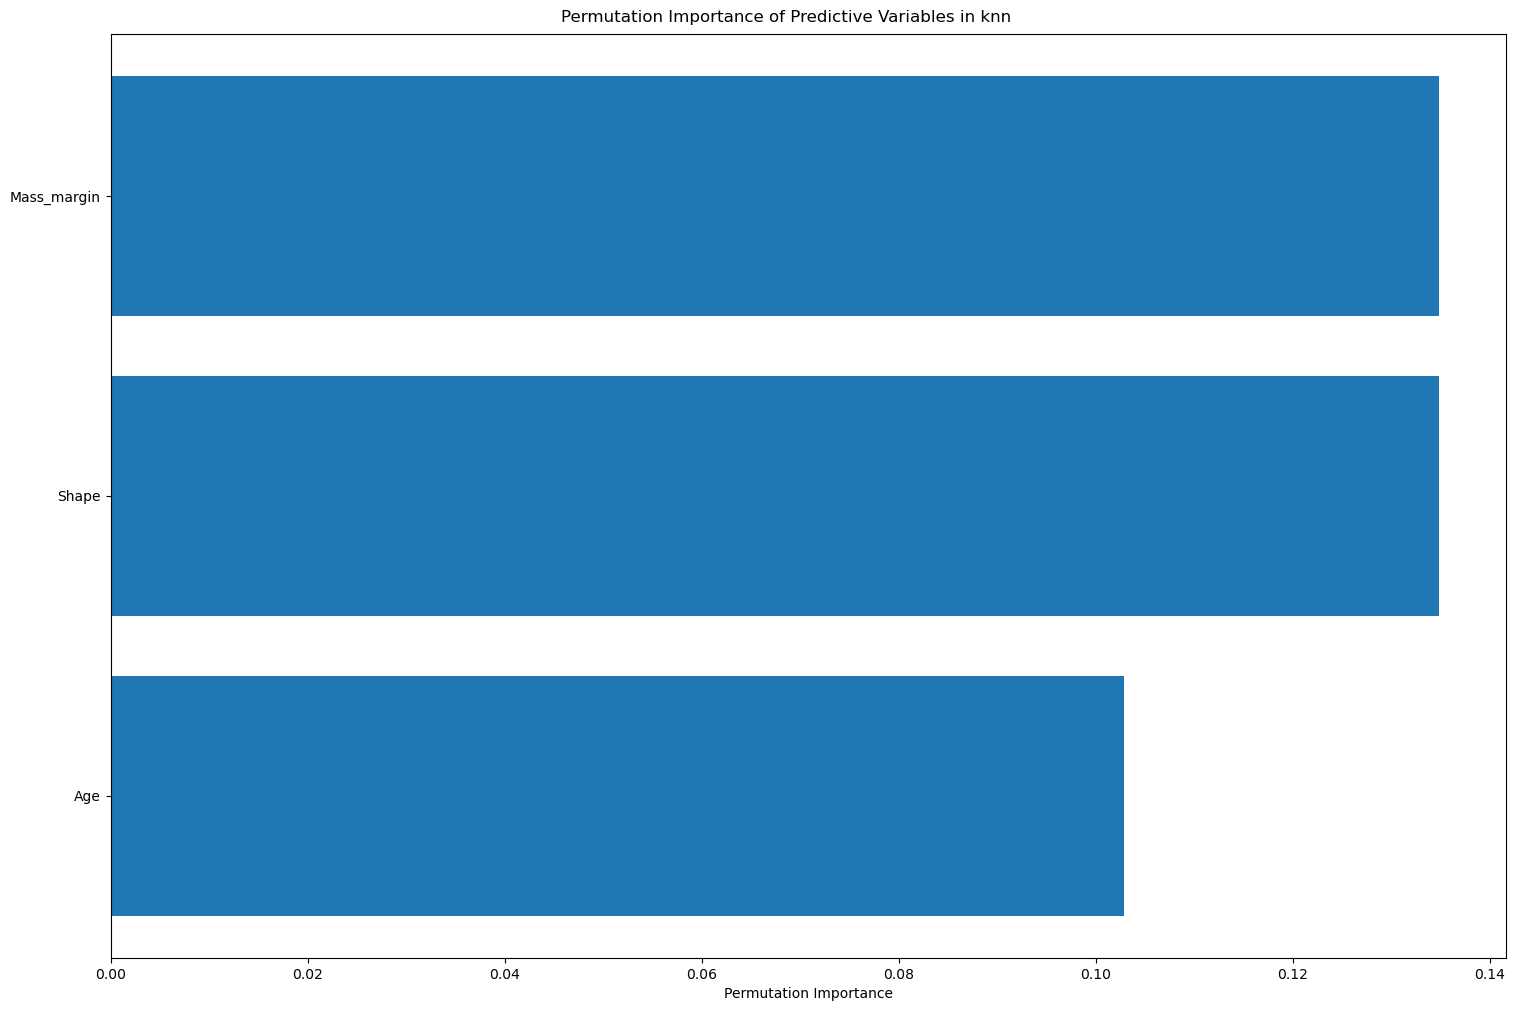

In [375]:
### Figure 15

## Testing perm_importance to see which features contribute most to the model

## perm_importance is only used on test set 
perm_importance_knn = permutation_importance(knn, X_test_scaled, y_test)

#creating list of feature names
feature_names = ['Age', 'Shape', 'Mass_margin']

#converting feature_names for array for plot 
features = np.array(feature_names)

title = 'Permutation Importance of Predictive Variables in knn'
#_________________________________

### Figure 15
## plotting the permuation importance vs. feature to see how much each feature contributes to model
sorted_idx_knn = perm_importance_knn.importances_mean.argsort()
plt.barh(features[sorted_idx_knn], perm_importance_knn.importances_mean[sorted_idx_knn])
plt.xlabel("Permutation Importance")
plt.suptitle(title, y = 0.9)

## k-NN (with hyper-parameter selection)

## "best k"

### Figure 16

Minimum error:- 0.14285714285714285 at K = 18


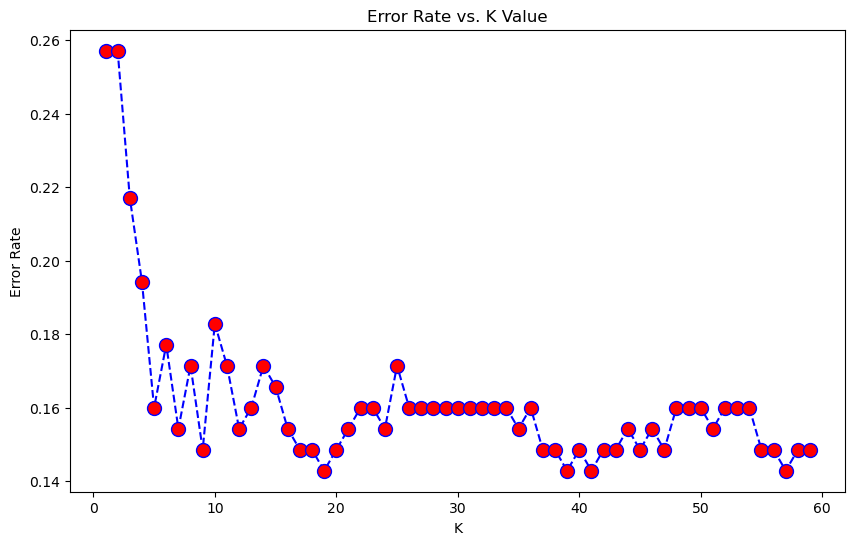

In [376]:
### creating a loop that will test different k values (n_neighbors)
#the end of the loop will append the error_rate so that it can be plotted against its k value

error_rate = []

for i in range(1,60):
 knn = KNeighborsClassifier(n_neighbors = i, metric= 'minkowski', weights = 'uniform')
 knn.fit(X_train_scaled,y_train)
 pred_i = knn.predict(X_test_scaled)
 error_rate.append(np.mean(pred_i != y_test))

#___________________________

### Figure 16
## plotting the error rate vs. K Value to find the K value with the minimum error rate

plt.figure(figsize=(10,6))
plt.plot(range(1,60),error_rate,color='blue', linestyle='dashed', 
         marker='o',markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')

print("Minimum error:-",min(error_rate),"at K =",error_rate.index(min(error_rate)))

### Figure 17

Maximum roc_auc:- 0.8605945521215296 at K = 56


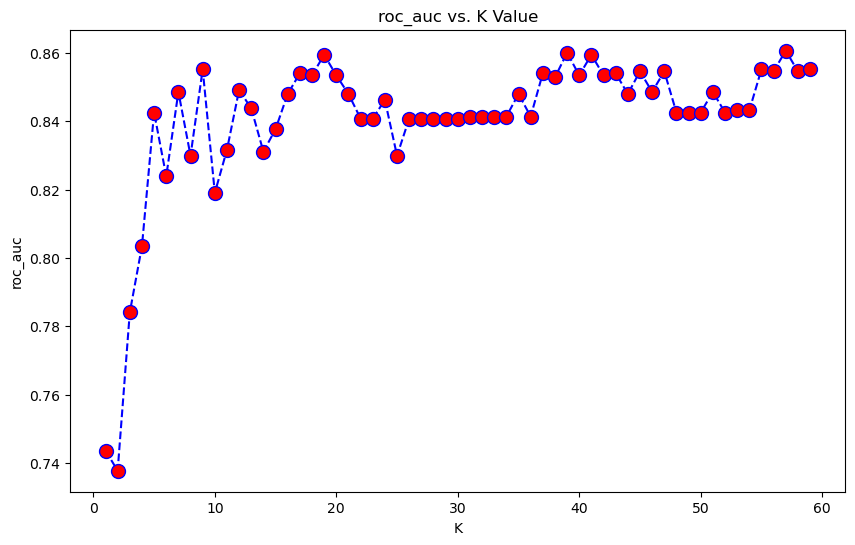

In [377]:
### creating a loop that will test different k values (n_neighbors)
#the end of the loop will append the roc_auc so that it can be plotted against its k value

roc_auc = [] 

for i in range(1,60):
    neigh = KNeighborsClassifier(n_neighbors = i, metric= 'minkowski', weights = 'uniform').fit(X_train_scaled,y_train)
    yhat = neigh.predict(X_test_scaled)
    roc_auc.append(metrics.roc_auc_score(y_test, yhat))
    
### Figure 17
## plotting the roc_auc vs. K Value to find the K value with the maximum roc_auc score
plt.figure(figsize=(10,6))
plt.plot(range(1,60),roc_auc,color = 'blue',linestyle='dashed', 
         marker='o',markerfacecolor='red', markersize=10)
plt.title('roc_auc vs. K Value')
plt.xlabel('K')
plt.ylabel('roc_auc')
print("Maximum roc_auc:-",max(roc_auc),"at K =",roc_auc.index(max(roc_auc)))

### Fitting the model with new hyper-parameters

In [378]:
## Using the k at maxmum roc_auc () to tune model
#knn_bk standads to k-NN with best k (bk)

#creating a variable for the tuned model
knn_bk = KNeighborsClassifier(n_neighbors = (roc_auc.index(max(roc_auc))))

#fitting tuned model to the data 
knn_bk.fit(X_train_scaled,y_train)

KNeighborsClassifier(n_neighbors=56)

In [379]:
## X_train_scaled 

#predicting severity score based off training values 
y_pred_train_bk = knn_bk.predict(X_train_scaled)

#cross validation (CV) scores for training data
cv_score_train_bk = cross_val_score(knn_bk, X_train_scaled,y_train, cv=10, scoring='roc_auc')

#mean CV score (of 10)
print(f"The average CV score on training set = {round(cv_score_train_bk.mean(), 3)}")
print('\n')

#classification report using y_train vs. y__train_predicted 
print('Classification report for training set (k_NN_bk)')
print(classification_report(y_train, y_pred_train_bk))

print('\n')

score_knn_train_bk = knn_bk.score(X_train_scaled, y_train)
print(f"R^2(coefficient of determination) on training set = {round(score_knn_train_bk, 3)}")

The average CV score on training set = 0.847


Classification report for training set (k_NN_bk)
              precision    recall  f1-score   support

           0       0.83      0.73      0.78       372
           1       0.77      0.85      0.81       386

    accuracy                           0.79       758
   macro avg       0.80      0.79      0.79       758
weighted avg       0.80      0.79      0.79       758



R^2(coefficient of determination) on training set = 0.793


In [380]:
## X_test_scaled 

#predicting severity score based of test values 
y_pred_test_bk = knn_bk.predict(X_test_scaled)

#cross validation (CV) scores for test data 
cv_score_test_bk = cross_val_score(knn_bk, X_test_scaled,y_test, cv=10, scoring='roc_auc')

print(f"The average CV score on test set = {round(cv_score_test_bk.mean(), 3)}")
print('\n')

#classification report using y_test vs. y_predicted 
print('Classification report for training set (k_NN_bk)')
print(classification_report(y_test, y_pred_test_bk))

print('\n')
#printing the roc_auc score for the test set 
print("Test ROC score:",roc_auc_score(y_pred_test_bk, y_test))

score_knn_test_bk = knn_bk.score(X_test_scaled, y_test)
print(f"R^2(coefficient of determination) on testing set = {round(score_knn_test_bk, 3)}")

The average CV score on test set = 0.902


Classification report for training set (k_NN_bk)
              precision    recall  f1-score   support

           0       0.91      0.79      0.85        92
           1       0.80      0.92      0.85        83

    accuracy                           0.85       175
   macro avg       0.86      0.85      0.85       175
weighted avg       0.86      0.85      0.85       175



Test ROC score: 0.8562500000000001
R^2(coefficient of determination) on testing set = 0.851


### visualization of model outcomes 

### Figure 18

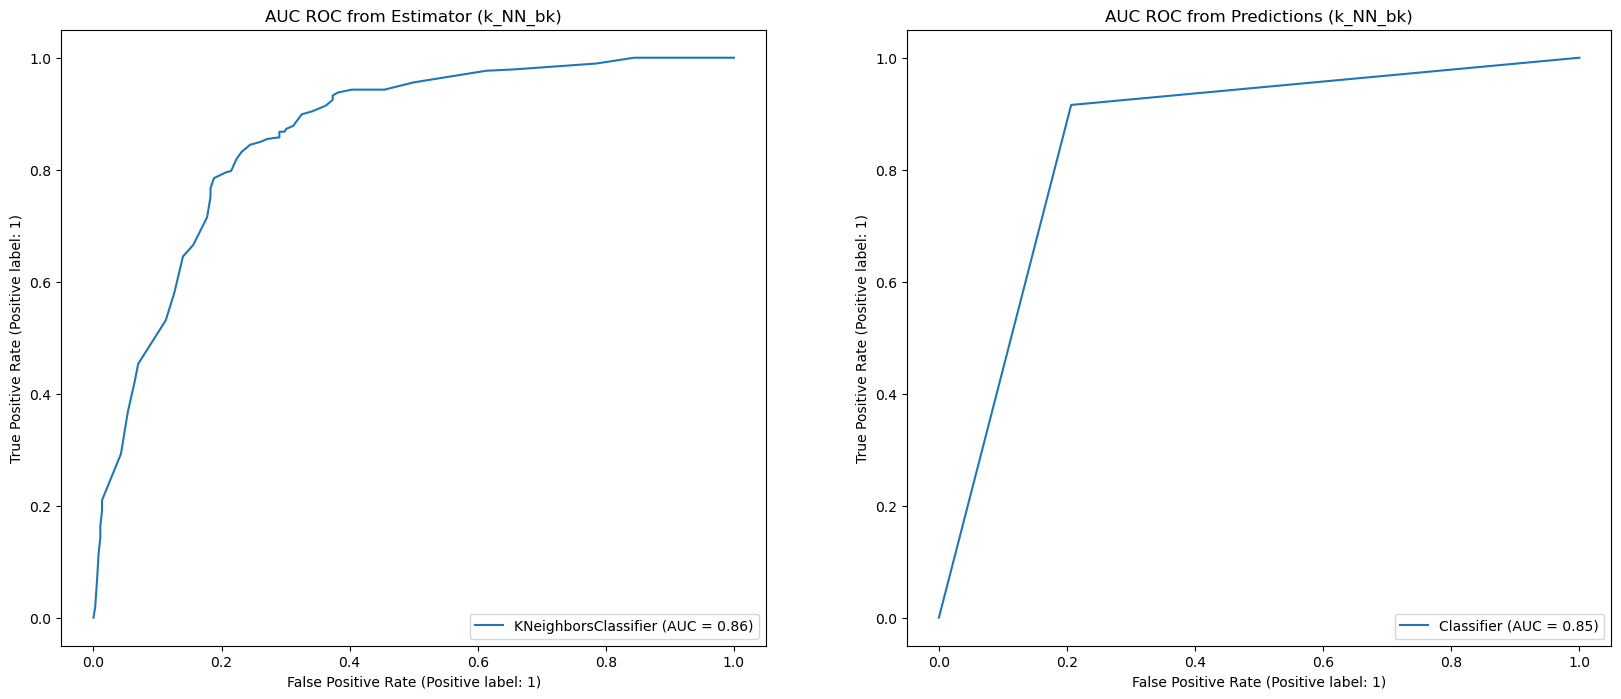

In [381]:
### Figure 18
#displaying roc_auc for test data 

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,8))

#'from_estimator' plots the ROC curve on the model that has already been fit to data
RocCurveDisplay.from_estimator(knn_bk, X_train_scaled, y_train, ax = ax1)
ax1.set_title('AUC ROC from Estimator (k_NN_bk)')
#'from_predictor' plots the ROC curve using predicted scores or probabilities and the true binary labels
RocCurveDisplay.from_predictions(y_test, y_pred_test_bk, ax = ax2)
ax2.set_title('AUC ROC from Predictions (k_NN_bk)')
plt.show()

### Figure 19

Text(0.5, 0.98, 'KNN_bk Confusion Matrix')

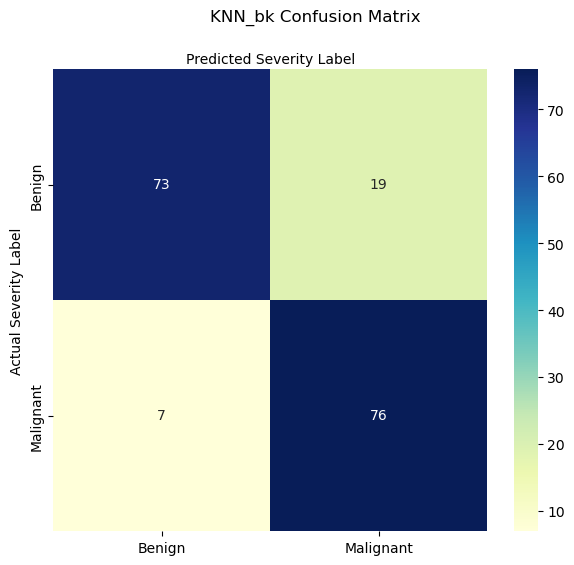

In [382]:
### Figure 19
##heatmap showing the confision matrix for TP, TN, FP, FN

#specifing plot parameters 
class_names = ['Benign', 'Malignant'] # name of classes 
title = 'KNN_bk Confusion Matrix'
ylabel = 'Actual Severity Label'
xlabel = 'Predicted Severity Label'
tick_marks = [0.5, 1.5]
data = pd.DataFrame(confusion_matrix(y_test, y_pred_test_bk))
figsize = (7,6)

#plot figure
fig, ax = plt.subplots(figsize=figsize)
sns.heatmap(data, annot=True, cmap="YlGnBu", fmt='g')
ax.xaxis.set_label_position("top")
plt.ylabel(ylabel)
plt.xlabel(xlabel)
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
plt.suptitle(title)

### Figure 20

Text(0.5, 0.9, 'Permutation Importance of Predictive Variables in knn_bk')

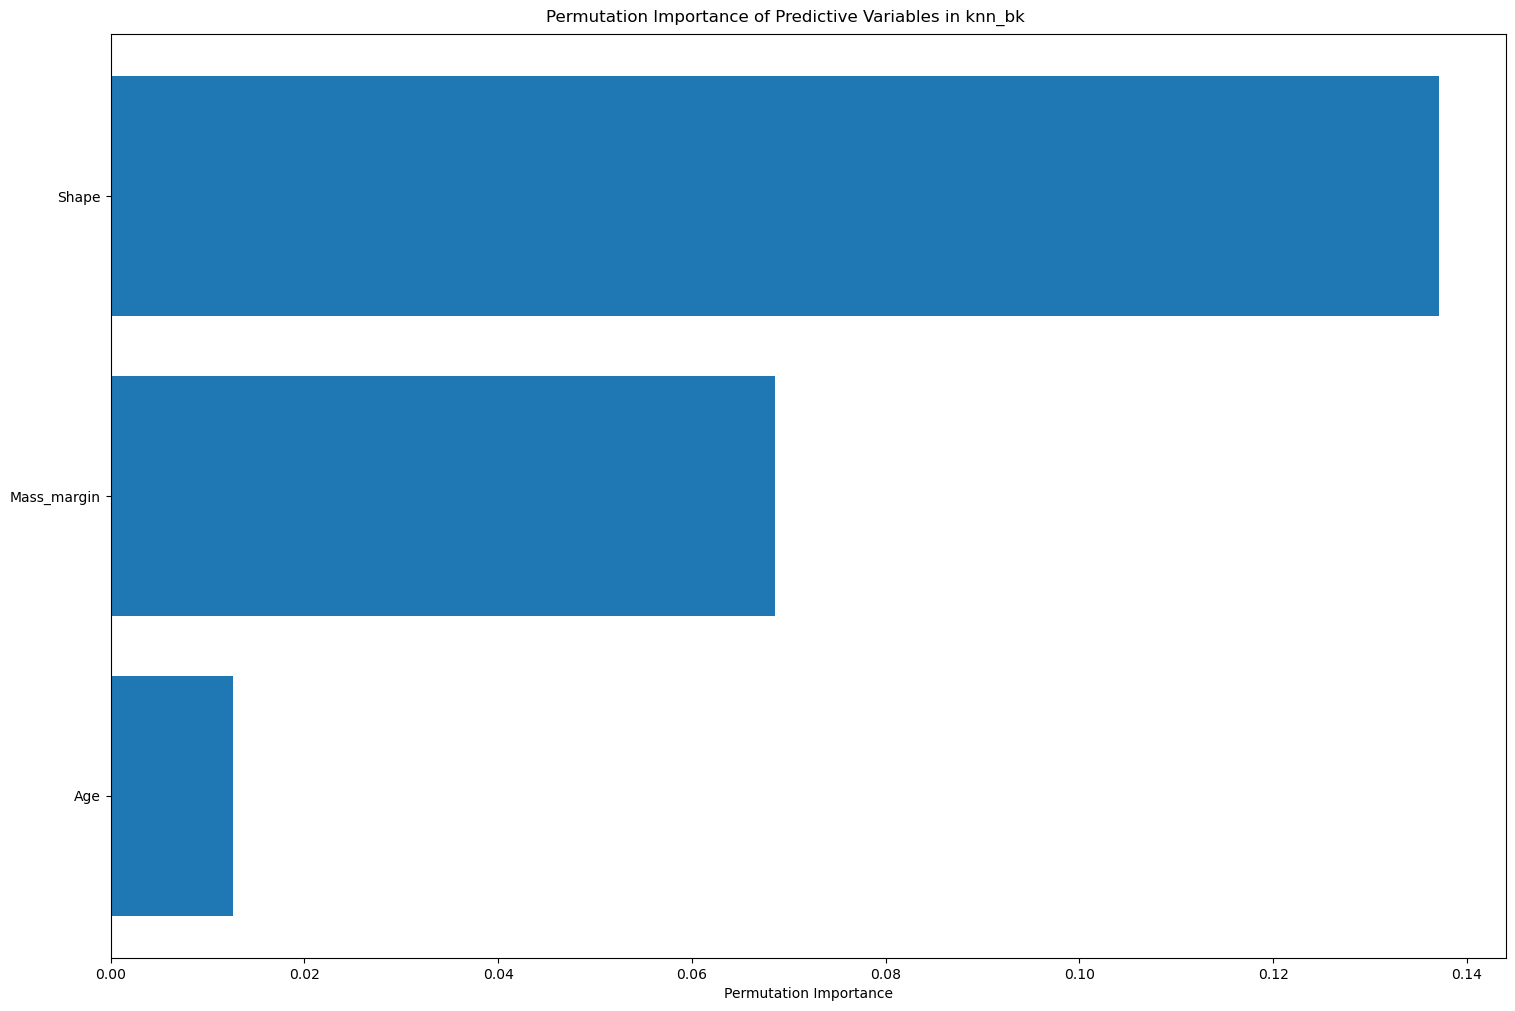

In [383]:
### Testing perm_importance to see which features contribute most to the model

## perm_importance is only used on test set 
perm_importance_bk = permutation_importance(knn_bk, X_test_scaled, y_test)

#creating list of feature names
feature_names = ['Age', 'Shape', 'Mass_margin']

#converting feature_names for array for plot 
features = np.array(feature_names)
title = 'Permutation Importance of Predictive Variables in knn_bk'

#_________________________________

### Figure 20
## plotting the permuation importance vs. feature to see how much each feature contributes to model
sorted_idx_bk = perm_importance_bk.importances_mean.argsort()
plt.barh(features[sorted_idx_bk], perm_importance_bk.importances_mean[sorted_idx_bk])
plt.xlabel("Permutation Importance")
plt.suptitle(title, y = 0.9)

# SVC

### Pseudocode for SVC

## SVC (without hyper-parameter selection)

In [384]:
## instantiating and fitting SVC model
svc = SVC(random_state=42)
svc.fit(X_train_scaled, y_train)
print(svc.get_params())

{'C': 1.0, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': -1, 'probability': False, 'random_state': 42, 'shrinking': True, 'tol': 0.001, 'verbose': False}


In [385]:
### X_train
#predicting severity score based of training values 
y_pred_train_svc = svc.predict(X_train_scaled)

#cross validation (CV) scores for training data
cv_score_train_svc = cross_val_score(svc, X_train_scaled, y_train, cv=10, scoring='roc_auc')
#mean CV score (of 10)
print(f"The average CV score on training set = {round(cv_score_train_svc.mean(), 3)}")
print('\n')

print('Classification report for training set (SVC)')
print(classification_report(y_train, y_pred_train_svc))


score_svc_train = svc.score(X_train_scaled, y_train)
print(f"R^2(coefficient of determination) on training set = {round(score_svc_train, 3)}")

The average CV score on training set = 0.836


Classification report for training set (SVC)
              precision    recall  f1-score   support

           0       0.83      0.76      0.79       372
           1       0.78      0.85      0.82       386

    accuracy                           0.80       758
   macro avg       0.81      0.80      0.80       758
weighted avg       0.81      0.80      0.80       758

R^2(coefficient of determination) on training set = 0.805


In [386]:
### X_test 
#predicting severity score based of test values 
y_pred_test_svc = svc.predict(X_test_scaled)

#cross validation (CV) scores for test data 
cv_score_test_svc = cross_val_score(svc, X_test_scaled,y_test, cv=10, scoring='roc_auc')

print(f"The average CV score on testing set = {round(cv_score_test_svc.mean(), 3)}")
print('\n')


#classification report using y_test vs. y_predicted 
print('Classification report for testing set (SVC)')
print(classification_report(y_test, y_pred_test_svc))

score_svc_test = svc.score(X_test_scaled, y_test)
print(f"R^2(coefficient of determination) on testing set = {round(score_svc_test, 3)}")

The average CV score on testing set = 0.888


Classification report for testing set (SVC)
              precision    recall  f1-score   support

           0       0.90      0.80      0.85        92
           1       0.81      0.90      0.85        83

    accuracy                           0.85       175
   macro avg       0.85      0.85      0.85       175
weighted avg       0.86      0.85      0.85       175

R^2(coefficient of determination) on testing set = 0.851


### visualization of model outcomes 

### Figure 21

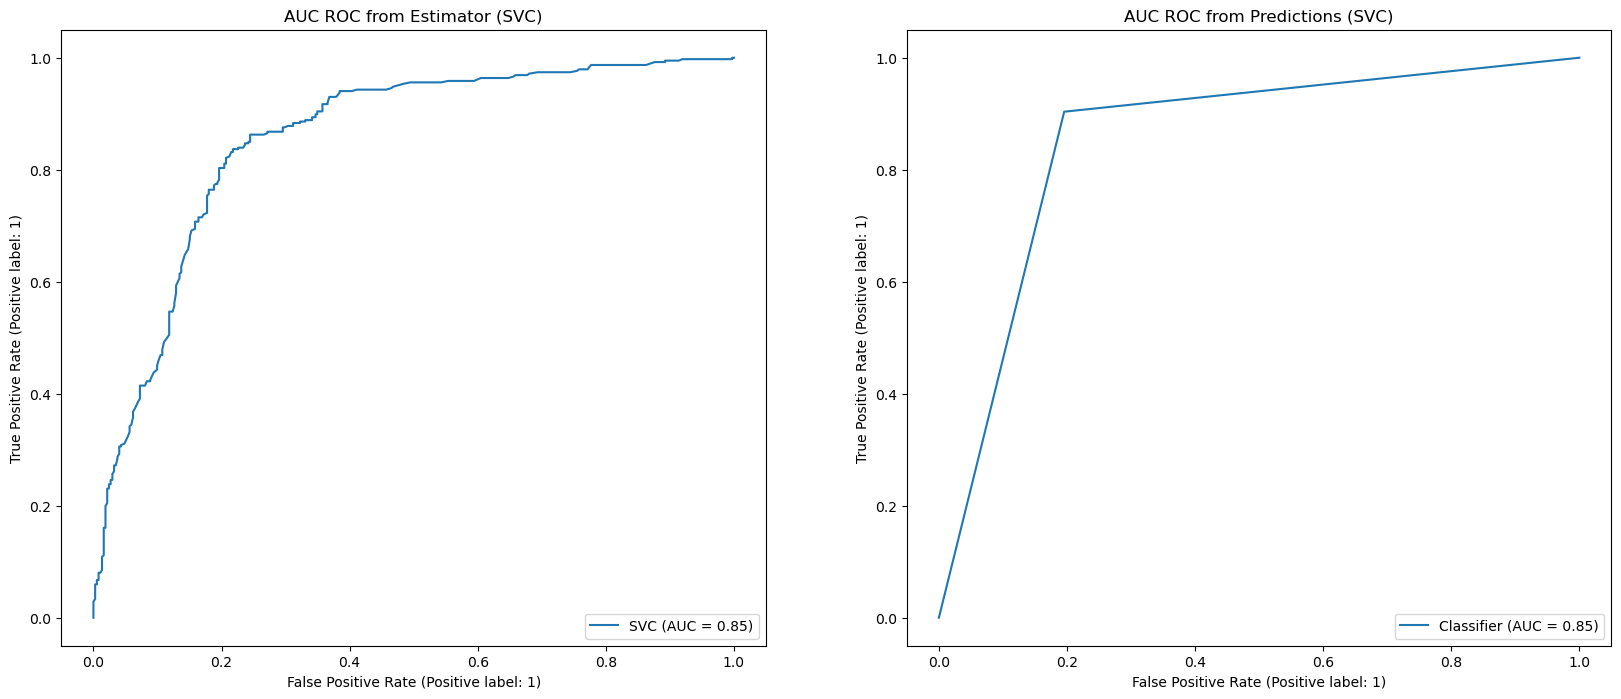

In [387]:
#visualization of ROC 
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,8))
RocCurveDisplay.from_estimator(svc, X_train_scaled, y_train, ax = ax1)
ax1.set_title('AUC ROC from Estimator (SVC)')
RocCurveDisplay.from_predictions(y_test, y_pred_test_svc, ax = ax2)
ax2.set_title('AUC ROC from Predictions (SVC)')
plt.show()

### Figure 22

Text(0.5, 0.98, 'SVC Confusion Matrix')

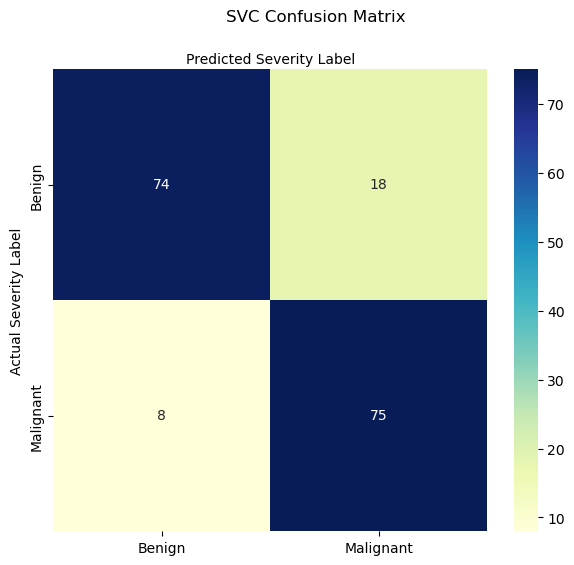

In [388]:
### Figure 22
##heatmap showing the confusion matrix for TP, TN, FP, FN

#specifing plot parameters 
class_names = ['Benign', 'Malignant'] # name of classes 
title = 'SVC Confusion Matrix'
ylabel = 'Actual Severity Label'
xlabel = 'Predicted Severity Label'
tick_marks = [0.5, 1.5]
data_svc = pd.DataFrame(confusion_matrix(y_test, y_pred_test_svc))
figsize = (7,6)

#plot figure
fig, ax = plt.subplots(figsize=figsize)
sns.heatmap(data_svc, annot=True, cmap="YlGnBu", fmt='g')
ax.xaxis.set_label_position("top")
plt.ylabel(ylabel)
plt.xlabel(xlabel)
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
plt.suptitle(title)

### Figure 23

Text(0.5, 0.9, 'Permutation Importance of Predictive Variables in SVC')

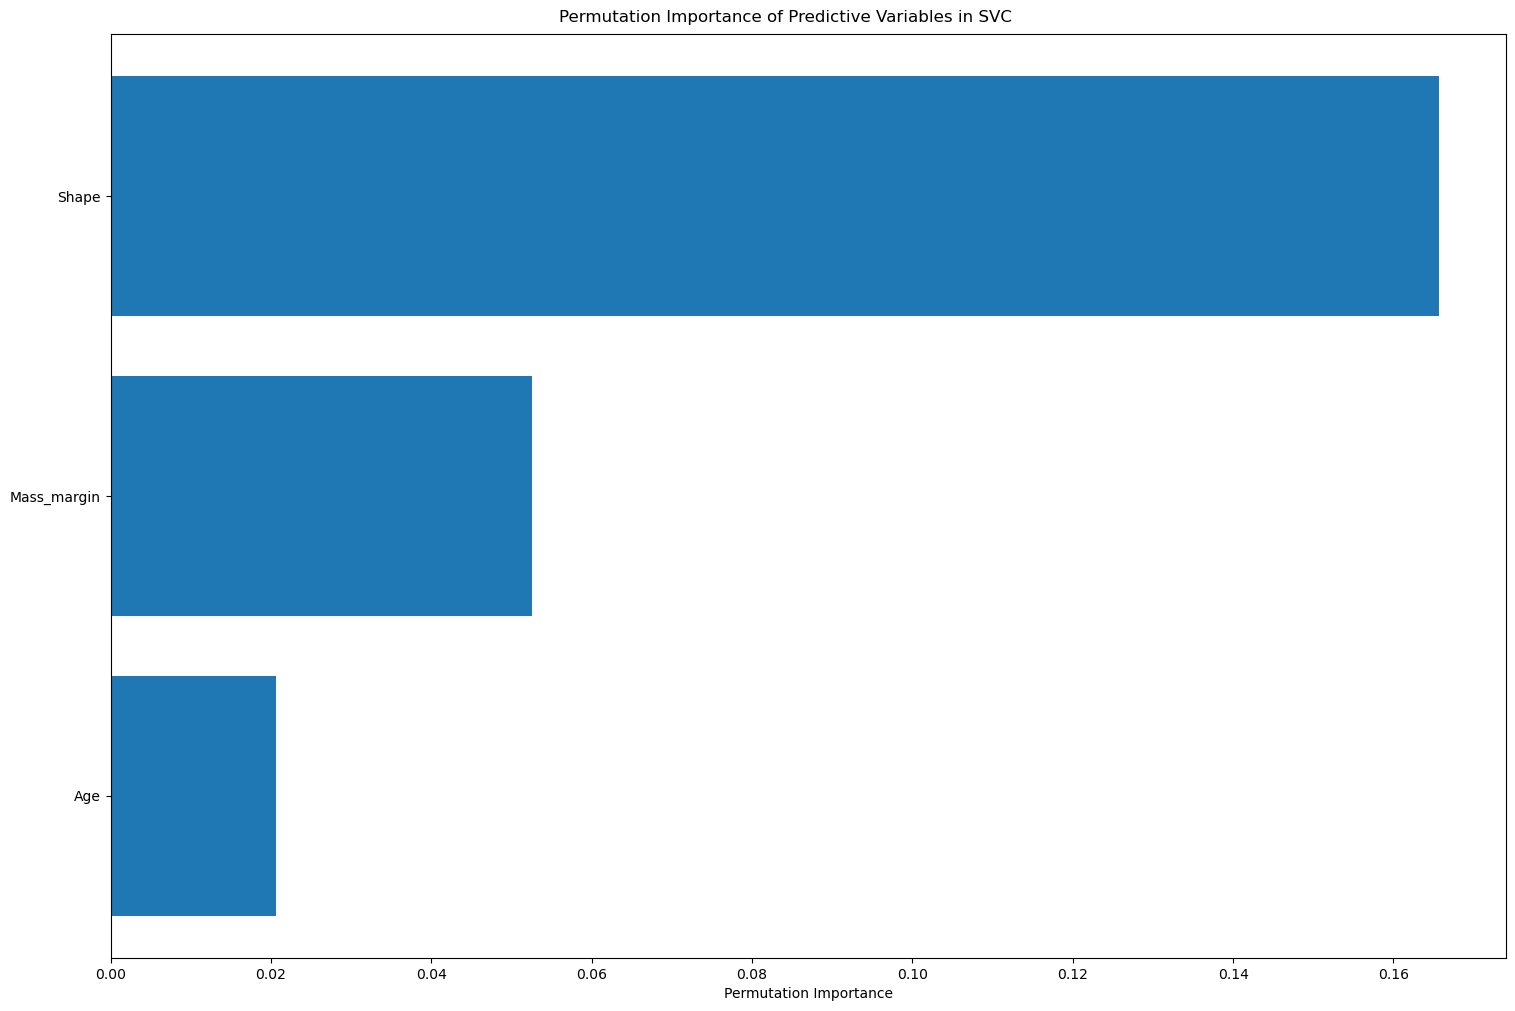

In [389]:
perm_importance_svc = permutation_importance(svc, X_test_scaled, y_test)

feature_names = ['Age', 'Shape', 'Mass_margin']
features = np.array(feature_names)
title = 'Permutation Importance of Predictive Variables in SVC'


###Figure 23
sorted_idx_svc = perm_importance_svc.importances_mean.argsort()
plt.barh(features[sorted_idx_svc], perm_importance_svc.importances_mean[sorted_idx_svc])
plt.xlabel("Permutation Importance")
plt.suptitle(title, y = 0.9)

## SVC (with hyper-parameter selection)

In [390]:
#looking for the best hyper-parameters to improve model 
param_grid = { 'C':[0.1,1,10],
              'gamma': [1, 0.1, 0.01, 0.001],
              'kernel':['rbf', 'linear']}
svc_grid = GridSearchCV(SVC(random_state = 42),param_grid, refit=True, cv=10)
svc_grid.fit(X_train_scaled,y_train)


#----------------------------

print(svc_grid.best_params_)
print(svc_grid.score(X_test_scaled,y_test))
print('Best estimator: ', svc_grid.best_estimator_, ' \n')


{'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}
0.8571428571428571
Best estimator:  SVC(C=1, gamma=0.1, random_state=42)  



In [391]:
#fitting the data to the model 
svc_hp = svc_grid.best_estimator_
svc_hp.fit(X_train_scaled,y_train)
print(svc_hp.get_params())

{'C': 1, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 0.1, 'kernel': 'rbf', 'max_iter': -1, 'probability': False, 'random_state': 42, 'shrinking': True, 'tol': 0.001, 'verbose': False}


##### notes on hyperparameters 
- the kernel function is the parameter used to transform the data into a higher-dimension feature space
    - most comply the Radial Basis Function (RBF)
        - lends itself well for nonlinear classification problems
- the C parameter controls the trade-off between achieving a low train error and a low testing error.  
    -  small C value for non-linear models  means that the model will be more tolerant of misclassified training examples and may be able to capture more complex decisions boundaries
- Gamma controls the shape of the decision boundary and is sometimes referred to as the "spread" of the kernel
    - small value of gamma means that the decision boundary is relatively smooth and spread out, making it less prone to overfitting

In [392]:
###X_train

#predicting severity score based of train values 
y_pred_train_svc_hp = svc_hp.predict(X_train_scaled)

#cross validation (CV) scores for training data
cv_score_train_svc_hp = cross_val_score(svc_hp, X_train_scaled,y_train, cv=10, scoring='roc_auc')

#mean CV score (of 10)
print(f"The average CV score on training set = {round(cv_score_train_svc_hp.mean(), 3)}")
print('\n')

print('Classification report for training set (SVC_hp)')
print(classification_report(y_train, y_pred_train_svc_hp))

score_svc_train_hp = svc_hp.score(X_train_scaled, y_train)
print(f"R^2(coefficient of determination) on training set = {round(score_svc_train_hp, 3)}")

The average CV score on training set = 0.846


Classification report for training set (SVC_hp)
              precision    recall  f1-score   support

           0       0.83      0.72      0.77       372
           1       0.76      0.86      0.81       386

    accuracy                           0.79       758
   macro avg       0.80      0.79      0.79       758
weighted avg       0.80      0.79      0.79       758

R^2(coefficient of determination) on training set = 0.793


In [393]:
###X_test 

#predicting severity score based of test values 
y_pred_test_svc_hp = svc_hp.predict(X_test_scaled)

#cross validation (CV) scores for test data 
cv_score_test_svc_hp = cross_val_score(svc_hp, X_test_scaled,y_test, cv=10, scoring='roc_auc')
print(f"The average CV score on test set = {round(cv_score_test_svc_hp.mean(), 3)}")
print('\n')

#classification report using y_test vs. y_predicted 
print('Classification report for test set (SVC_hp)')
print(classification_report(y_test, y_pred_test_svc_hp))

score_svc_test_hp = svc_hp.score(X_test_scaled, y_test)
print(f"R^2(coefficient of determination) on test set = {round(score_svc_test_hp, 3)}")

The average CV score on test set = 0.899


Classification report for test set (SVC_hp)
              precision    recall  f1-score   support

           0       0.92      0.79      0.85        92
           1       0.80      0.93      0.86        83

    accuracy                           0.86       175
   macro avg       0.86      0.86      0.86       175
weighted avg       0.87      0.86      0.86       175

R^2(coefficient of determination) on test set = 0.857


### visualization of model outcomes 

### Figure 24

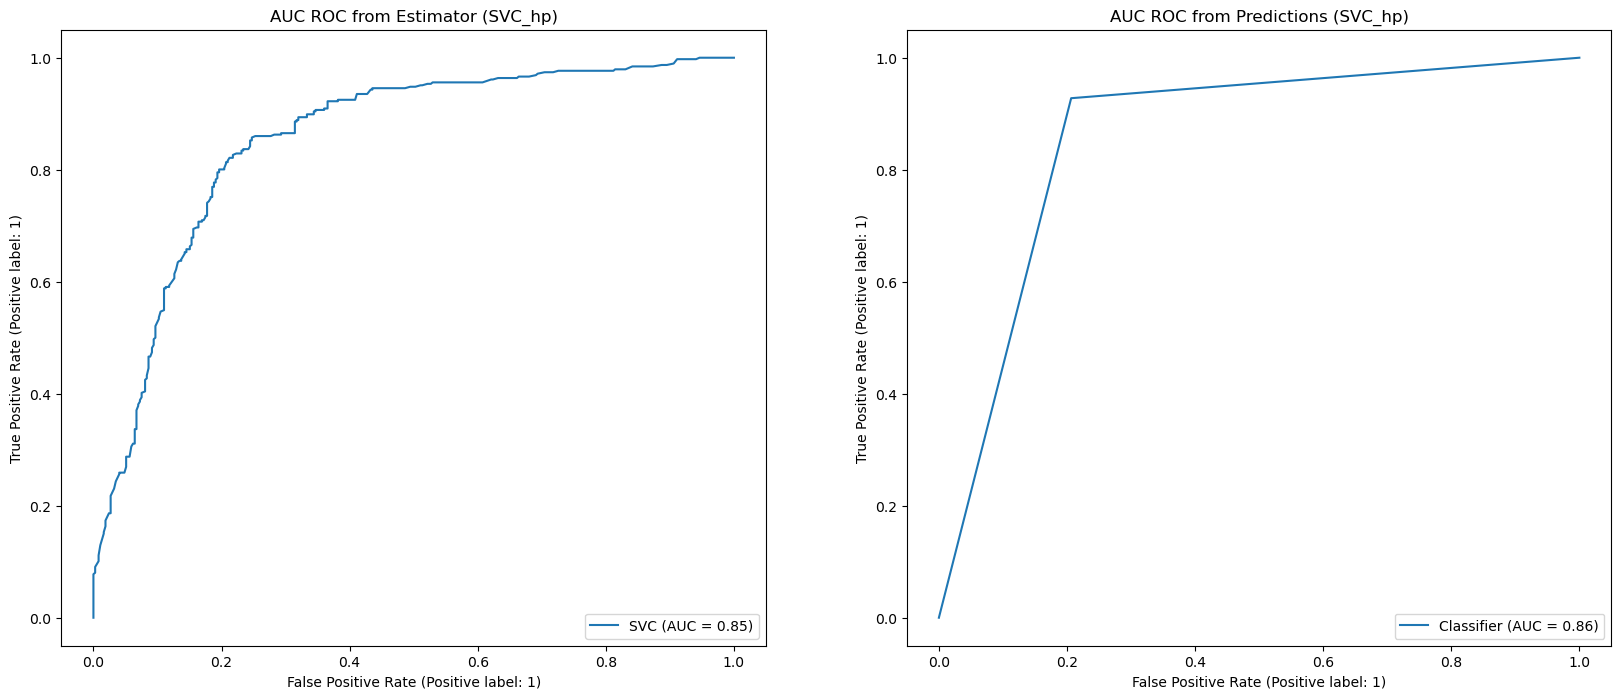

In [394]:
#visualization of ROC 

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,8))

RocCurveDisplay.from_estimator(svc_hp, X_train_scaled, y_train, ax = ax1)
ax1.set_title('AUC ROC from Estimator (SVC_hp)')
RocCurveDisplay.from_predictions(y_test, y_pred_test_svc_hp, ax = ax2)
ax2.set_title('AUC ROC from Predictions (SVC_hp)')
plt.show()

### Figure 25

Text(0.5, 0.98, 'SVC_hp Confusion Matrix')

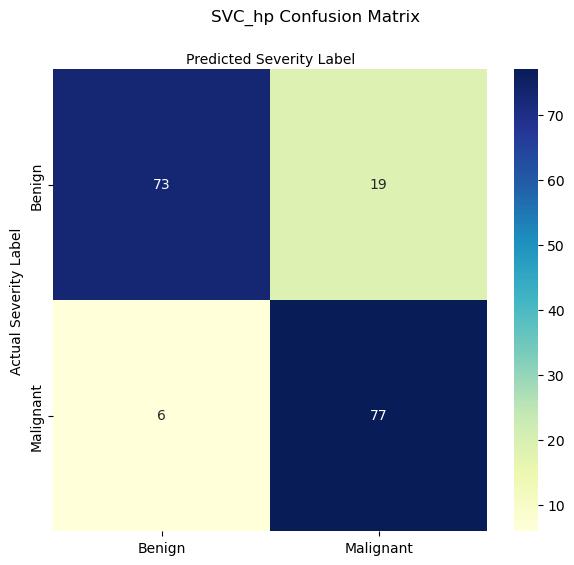

In [395]:
### Figure 25
##heatmap showing the confision matrix for TP, TN, FP, FN

#specifing plot parameters 
class_names = ['Benign', 'Malignant'] # name of classes 
title = 'SVC_hp Confusion Matrix'
ylabel = 'Actual Severity Label'
xlabel = 'Predicted Severity Label'
tick_marks = [0.5, 1.5]
data_svc_hp = pd.DataFrame(confusion_matrix(y_test, y_pred_test_svc_hp))
figsize = (7,6)

#plot figure
fig, ax = plt.subplots(figsize=figsize)
sns.heatmap(data_svc_hp, annot=True, cmap="YlGnBu", fmt='g')
ax.xaxis.set_label_position("top")
plt.ylabel(ylabel)
plt.xlabel(xlabel)
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
plt.suptitle(title)

### Figure 26

Text(0.5, 0.9, 'Permutation Importance of Predictive Variables in SVC_hp')

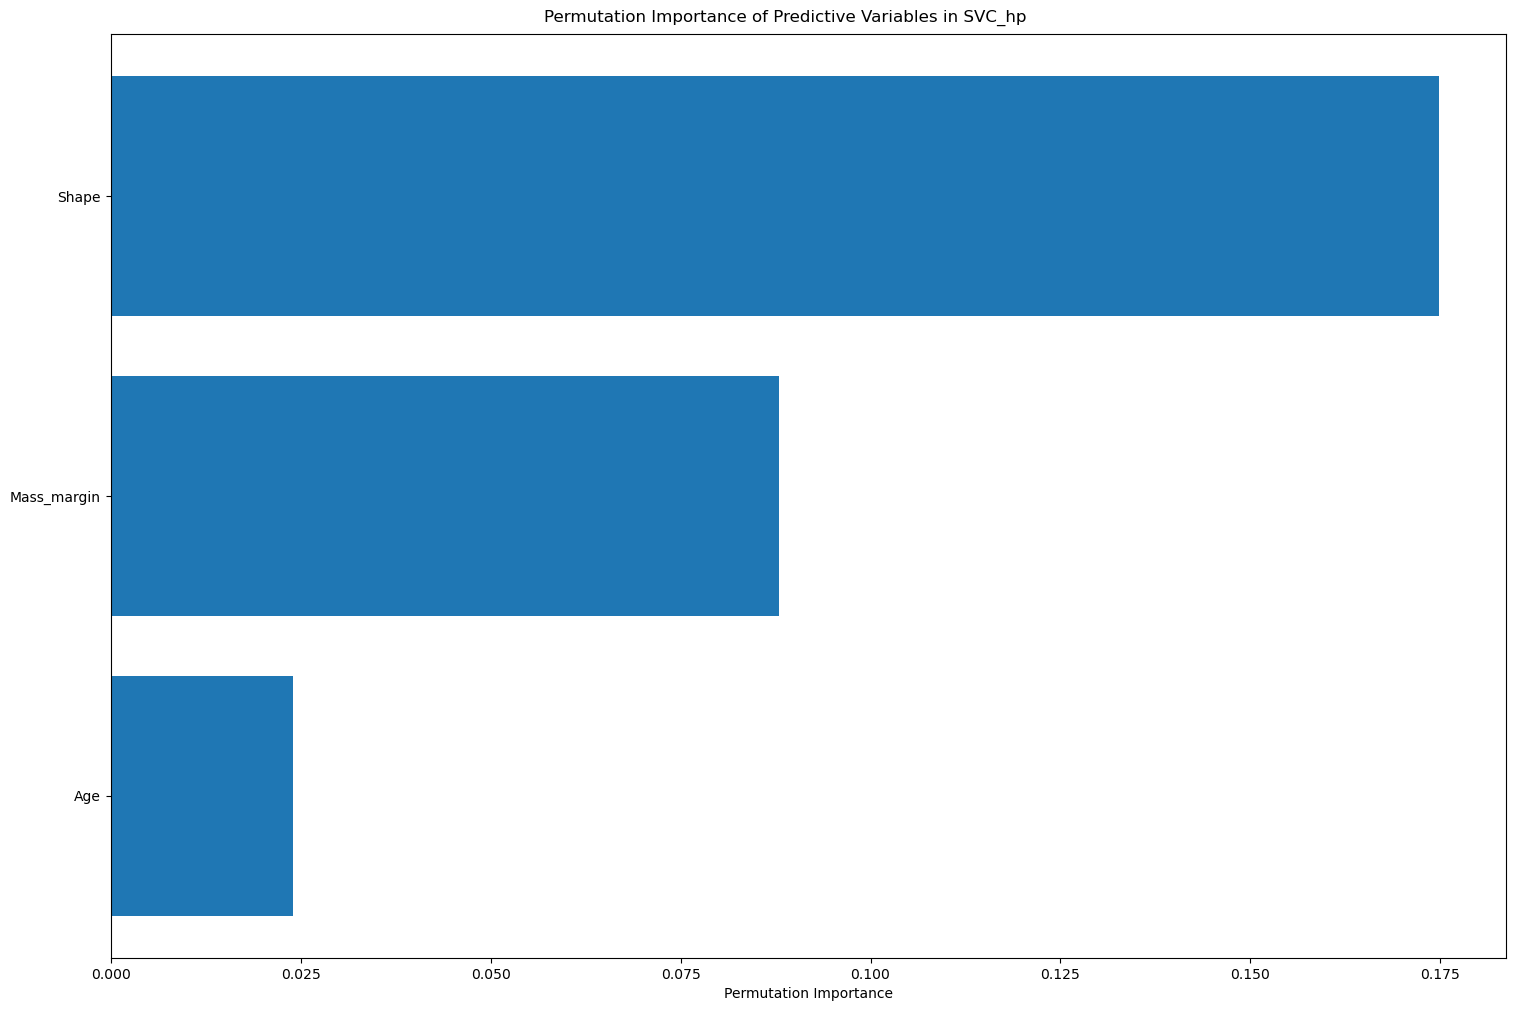

In [396]:
perm_importance_svc_hp = permutation_importance(svc_hp, X_test_scaled, y_test)

feature_names = ['Age', 'Shape', 'Mass_margin']
features = np.array(feature_names)
title = 'Permutation Importance of Predictive Variables in SVC_hp'

###Figure 26
sorted_idx_svc_hp = perm_importance_svc_hp.importances_mean.argsort()
plt.barh(features[sorted_idx_svc_hp], perm_importance_svc_hp.importances_mean[sorted_idx_svc_hp])
plt.xlabel("Permutation Importance")
plt.suptitle(title, y = 0.9)

# Model comparison 

### Classification report

In [397]:
## printing classification reports for test sets for each model to make comparision easier 

print('Classification report for test set (k_NN)')
print(classification_report(y_test, y_pred_test_knn))
print('\n')
print('Classification report for test set (k_NN_bk)')
print(classification_report(y_test, y_pred_test_bk))
print('\n')
print('Classification report for test set (SVC)')
print(classification_report(y_test, y_pred_test_svc))
print('\n')
print('Classification report for test set (SVC_hp)')
print(classification_report(y_test, y_pred_test_svc_hp))

Classification report for test set (k_NN)
              precision    recall  f1-score   support

           0       0.89      0.79      0.84        92
           1       0.80      0.89      0.84        83

    accuracy                           0.84       175
   macro avg       0.84      0.84      0.84       175
weighted avg       0.85      0.84      0.84       175



Classification report for test set (k_NN_bk)
              precision    recall  f1-score   support

           0       0.91      0.79      0.85        92
           1       0.80      0.92      0.85        83

    accuracy                           0.85       175
   macro avg       0.86      0.85      0.85       175
weighted avg       0.86      0.85      0.85       175



Classification report for test set (SVC)
              precision    recall  f1-score   support

           0       0.90      0.80      0.85        92
           1       0.81      0.90      0.85        83

    accuracy                           0.85       

### Figure 27

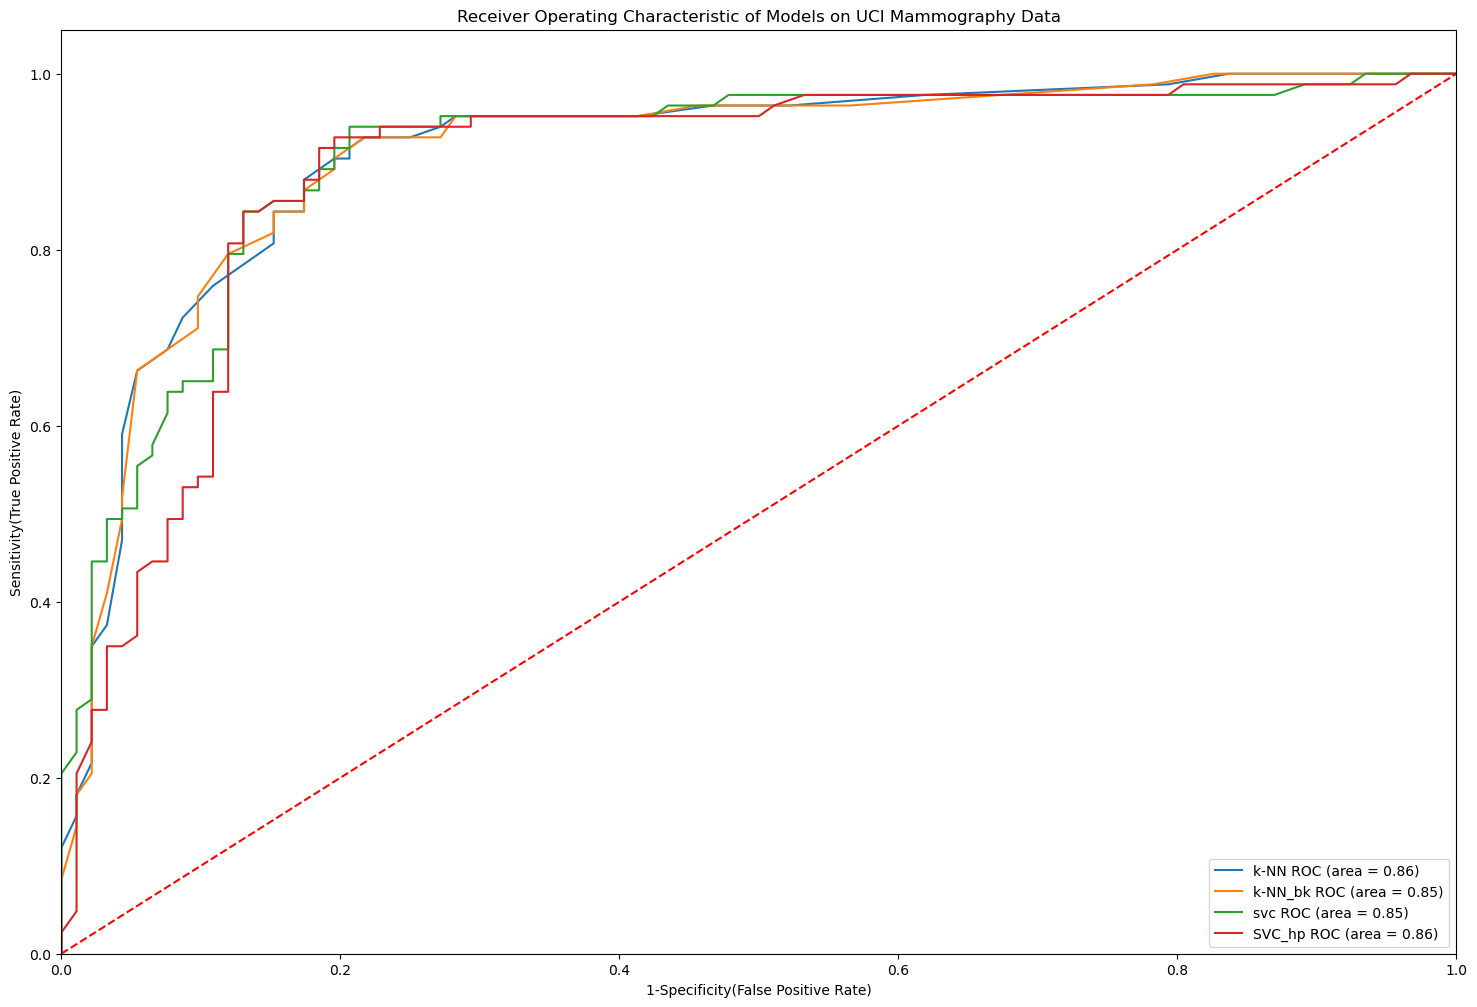

In [398]:
###Figure 27 

##plotting the roc_auc for each model tested 
# k-NN with and without hyper-parameter tuning 
# SVC with and without hyper-parameter tuning
# NB: SVC probability is set to true to be consistent with predict command

plt.figure()

# the models for ROC plot
models = [{
    'label': 'k-NN',
    'model': knn,
},{
    'label': 'k-NN_bk',
    'model': knn_bk,
},
    {
    'label': 'svc',
    'model': SVC(probability = True), 
},
{
    'label': 'SVC_hp',
    'model': SVC(C=0.1, degree=1, kernel='rbf', probability = True),
}
]


# for loop iterates through in models list
for m in models:
    model = m['model'] # selects the model
    model.fit(X_train_scaled, y_train) # trains the model
    y_pred=model.predict(X_test_scaled) # predicst the test data
    # Computes False postive rate (FPR), and True positive rate (TPR)
    fpr, tpr, thresholds = metrics.roc_curve(y_test, model.predict_proba(X_test_scaled)[:,1])
# Calculate Area under the curve to display on the plot
    roc_auc = metrics.roc_auc_score(y_test,model.predict(X_test_scaled))
# plots the computed values
    plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % (m['label'], roc_auc))
# Custom settings for the plot 
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity(False Positive Rate)')
plt.ylabel('Sensitivity(True Positive Rate)')
plt.title('Receiver Operating Characteristic of Models on UCI Mammography Data')
plt.legend(loc="lower right")
plt.show()   # Display

In [401]:
### creating a two-dimensional training set to visualize decisions boundaries

# based on the permutation importance, BI-RADs was consistently the most importance feature
# age was chosen as it was consistently ranked 2nd in all but one model 

#isolating BI-RADS and Age from training set
X_age = X_train[['Age', 'Shape']]

#scaling the data, so it can be used fit and train the model
X_age_scaled = scaler.fit_transform(X_age)

### Figure 28 
*(Decision boundaries (2D))*

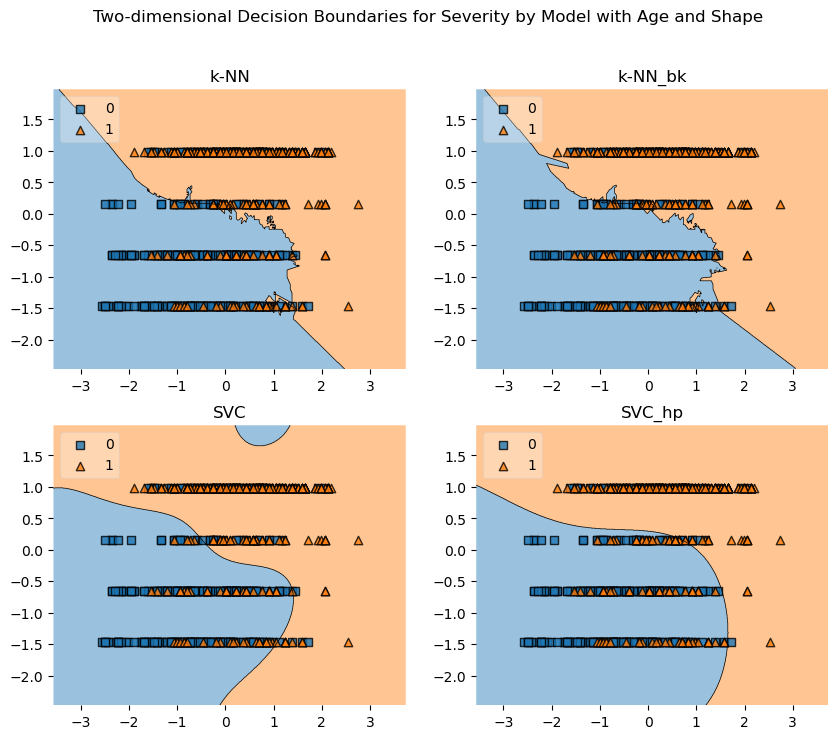

<Figure size 1800x1200 with 0 Axes>

In [407]:
### Figure 28
# Initializing Classifiers
clf1 = knn
clf2 = knn_bk
clf3 = svc
clf4 = svc_hp

gs = gridspec.GridSpec(2, 2)

fig = plt.figure(figsize=(10,8)) #creating gridspec dimensions 

labels = ['k-NN', 'k-NN_bk', 'SVC', 'SVC_hp'] #creating class labels 

#initializing a for loop that gets the classifier and label found within zip file 
#the dataframe is fitted to the classifer, then added to a subplot within gridspec 
for clf, lab, grd in zip([clf1, clf2, clf3, clf4],
                         labels,
                         itertools.product([0, 1], repeat=2)):

    clf.fit(X_age_scaled, y_train)
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = plot_decision_regions(X=X_age_scaled, y=y_train, clf=clf, legend=2) #decision regions plot
    plt.title(lab)

plt.suptitle('Two-dimensional Decision Boundaries for Severity by Model with Age and Shape')
plt.show()
plt.clf() #clearing graph data 

In [408]:
### creating a two-dimensional training set to visualize decisions boundaries

#isolating BI-RADS and Mass_Margin from training set
X_margin = X_train[['Age', 'Mass_Margin']] 

#scaling the data, so it can be used fit and train the model
X_margin_scaled = scaler.fit_transform(X_margin)

### Figure 29

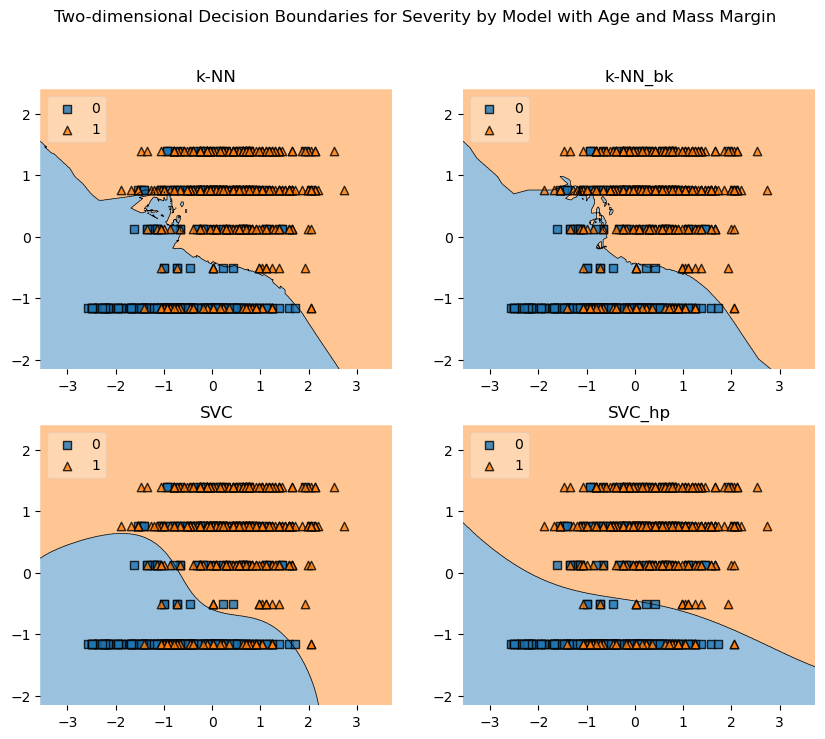

<Figure size 1800x1200 with 0 Axes>

In [409]:
### Figure 29
# Initializing Classifiers
clf1 = knn
clf2 = knn_bk
clf3 = svc
clf4 = svc_hp

gs = gridspec.GridSpec(2, 2) #creating gridspec dimensions 

fig = plt.figure(figsize=(10,8))

labels = ['k-NN', 'k-NN_bk', 'SVC', 'SVC_hp'] #creating class labels 

#initializing a for loop that gets the classifier and label found within zip file 
#the dataframe is fitted to the classifer, then added to a subplot within gridspec 
for clf, lab, grd in zip([clf1, clf2, clf3, clf4],
                         labels,
                         itertools.product([0, 1], repeat=2)):

    clf.fit(X_margin_scaled, y_train)
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = plot_decision_regions(X=X_margin_scaled, y=y_train, clf=clf, legend=2) #decision regions plot
    plt.title(lab)

plt.suptitle('Two-dimensional Decision Boundaries for Severity by Model with Age and Mass Margin')
plt.show()
plt.clf() #clearing graph data 